In [1]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lofo import LOFOImportance, plot_importance, Dataset
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import optuna
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import fbeta_score, make_scorer
from lime import lime_tabular
import shap
%matplotlib inline

/home/pledes/.local/lib/python3.8/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import os
os.chdir('../')

In [3]:
from my_functions import functions

## Chargement des données d'entrainement et de test

In [4]:
train = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
test = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')
print('Train set shape: ', train.shape)
print('Test set shape: ', test.shape)

Train set shape:  (307511, 122)
Test set shape:  (48744, 121)


In [5]:
os.chdir('notebooks/')

In [6]:
original_train = train.copy()

In [7]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [8]:
functions.missing_values(train)

Number of Missing Values  \
COMMONAREA_MEDI                             214865   
COMMONAREA_AVG                              214865   
COMMONAREA_MODE                             214865   
NONLIVINGAPARTMENTS_MEDI                    213514   
NONLIVINGAPARTMENTS_MODE                    213514   
...                                            ...   
EXT_SOURCE_2                                   660   
AMT_GOODS_PRICE                                278   
AMT_ANNUITY                                     12   
CNT_FAM_MEMBERS                                  2   
DAYS_LAST_PHONE_CHANGE                           1   

                          Percentage of Entries Missing  
COMMONAREA_MEDI                                    69.9  
COMMONAREA_AVG                                     69.9  
COMMONAREA_MODE                                    69.9  
NONLIVINGAPARTMENTS_MEDI                           69.4  
NONLIVINGAPARTMENTS_MODE                           69.4  
...                                                 ...  
EXT_SOURCE_2                                        0.2  
AMT_GOODS_PRICE                                     0.1  
AMT_ANNUITY                                         0.0  
CNT_FAM_MEMBERS                                     0.0  
DAYS_LAST_PHONE_CHANGE                              0.0  

[67 rows x 2 columns]

Certaines colonnes ont 70% de données manquantes

In [9]:
original_test = test.copy()

In [10]:
functions.missing_values(test)

Number of Missing Values  \
COMMONAREA_MODE                              33495   
COMMONAREA_MEDI                              33495   
COMMONAREA_AVG                               33495   
NONLIVINGAPARTMENTS_MEDI                     33347   
NONLIVINGAPARTMENTS_AVG                      33347   
...                                            ...   
OBS_60_CNT_SOCIAL_CIRCLE                        29   
DEF_30_CNT_SOCIAL_CIRCLE                        29   
OBS_30_CNT_SOCIAL_CIRCLE                        29   
AMT_ANNUITY                                     24   
EXT_SOURCE_2                                     8   

                          Percentage of Entries Missing  
COMMONAREA_MODE                                    68.7  
COMMONAREA_MEDI                                    68.7  
COMMONAREA_AVG                                     68.7  
NONLIVINGAPARTMENTS_MEDI                           68.4  
NONLIVINGAPARTMENTS_AVG                            68.4  
...                                                 ...  
OBS_60_CNT_SOCIAL_CIRCLE                            0.1  
DEF_30_CNT_SOCIAL_CIRCLE                            0.1  
OBS_30_CNT_SOCIAL_CIRCLE                            0.1  
AMT_ANNUITY                                         0.0  
EXT_SOURCE_2                                        0.0  

[64 rows x 2 columns]

## Pre-processing

### Types de données dispos

In [11]:
train_dtypes = pd.DataFrame(train.dtypes.value_counts()).reset_index()
train_dtypes.columns = ['dtypes', 'column count']

train_dtypes

dtypes  column count
0  float64            65
1    int64            41
2   object            16

16 colonnes ont besoin d'être encodées

In [12]:
train, test = functions.prepare_test(train, test)

## Kernel Densitiy Estimation

Plot KDE pour voir l'influence des différentes features sur la target.

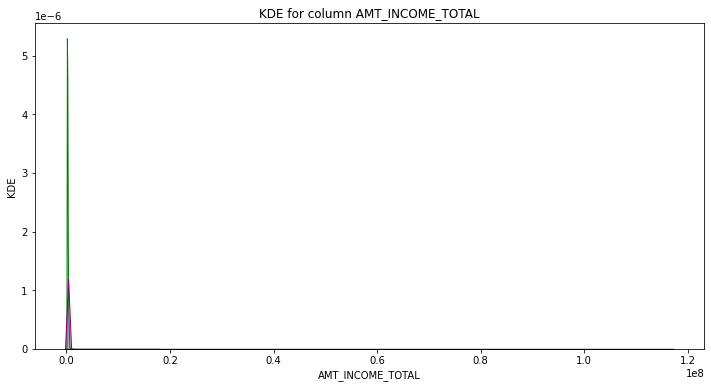

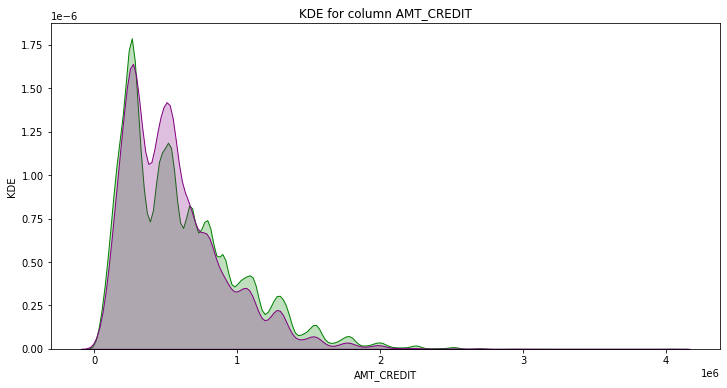

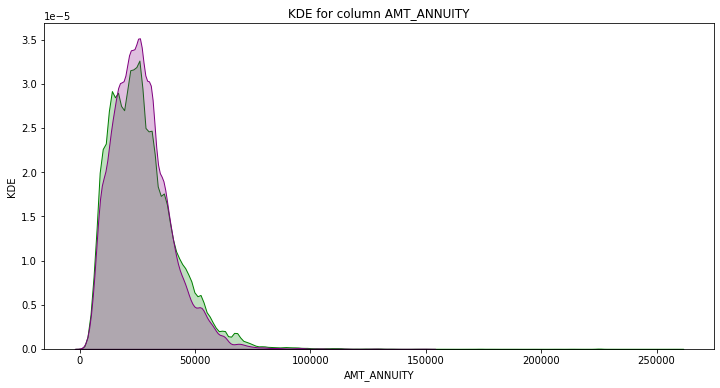

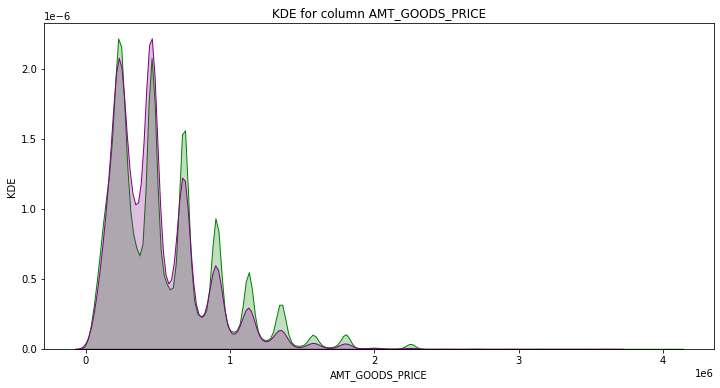

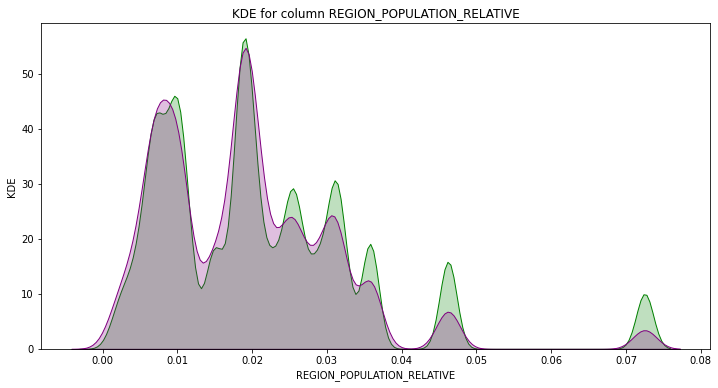

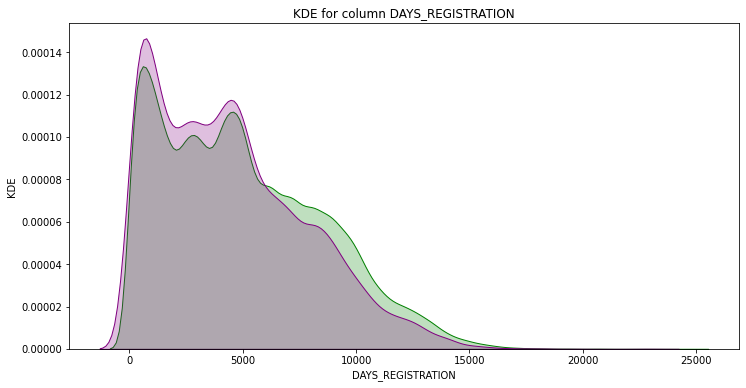

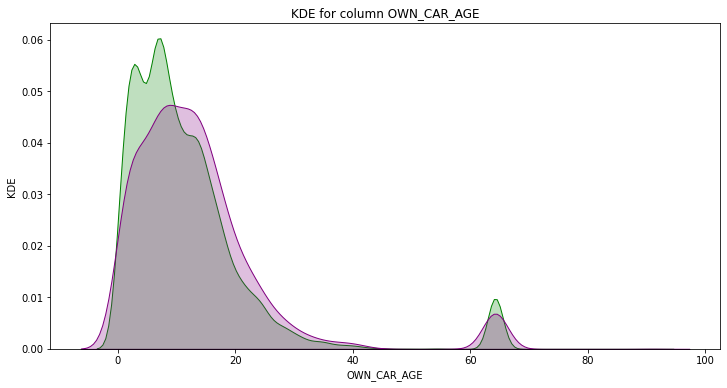

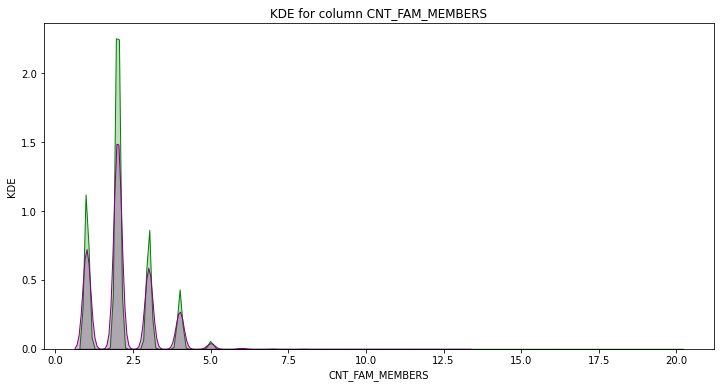

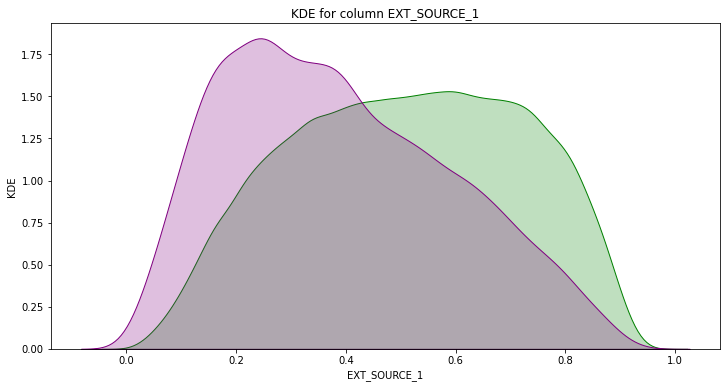

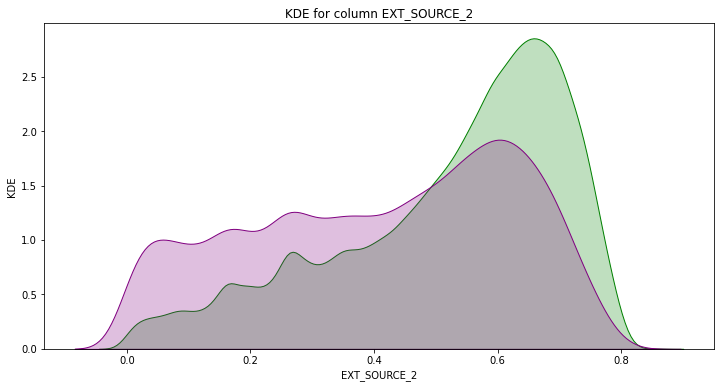

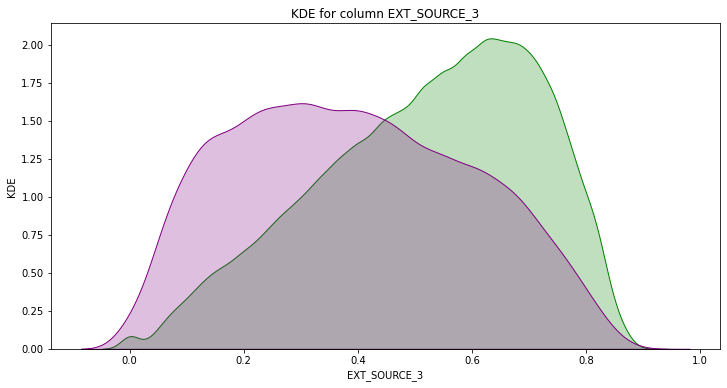

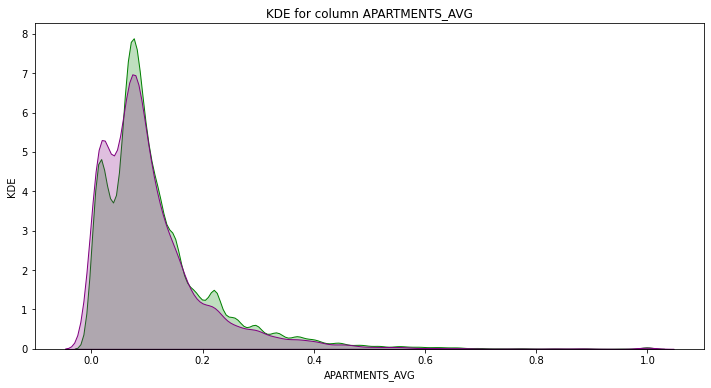

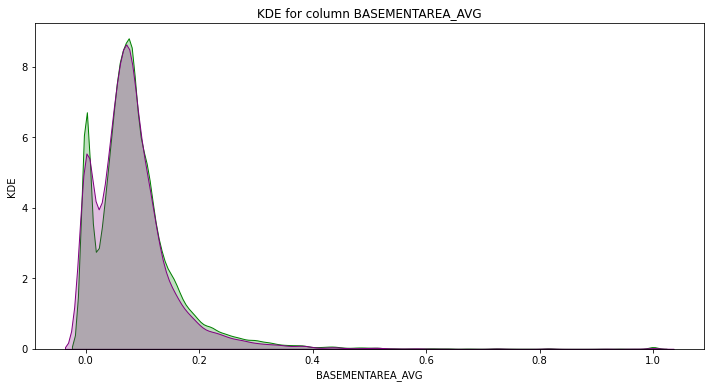

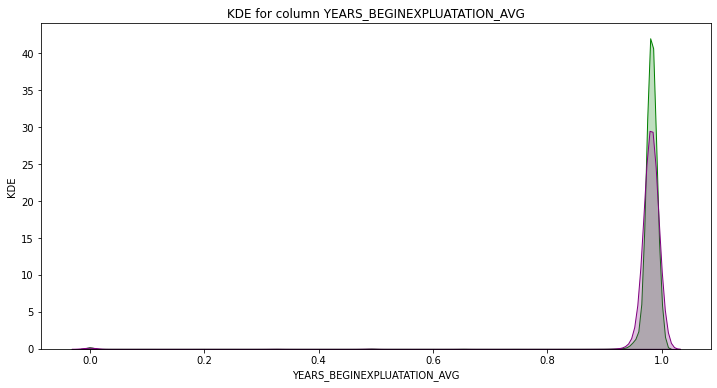

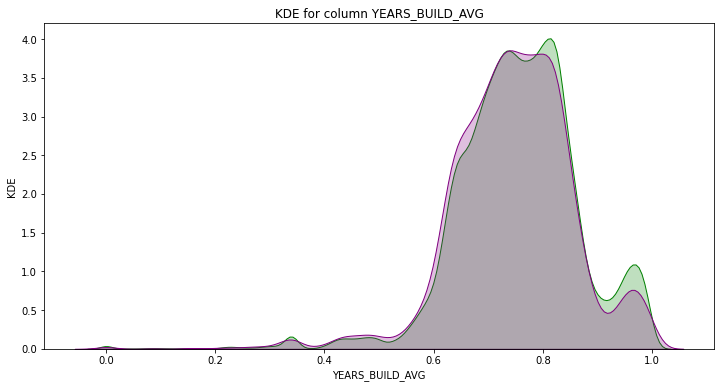

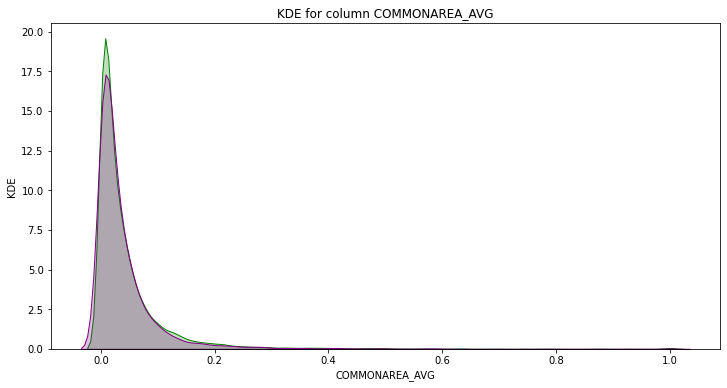

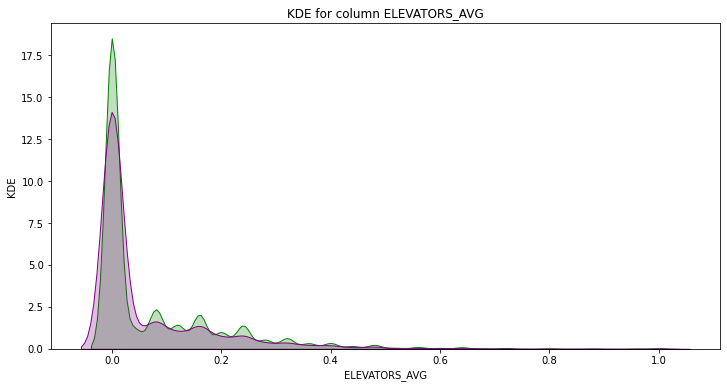

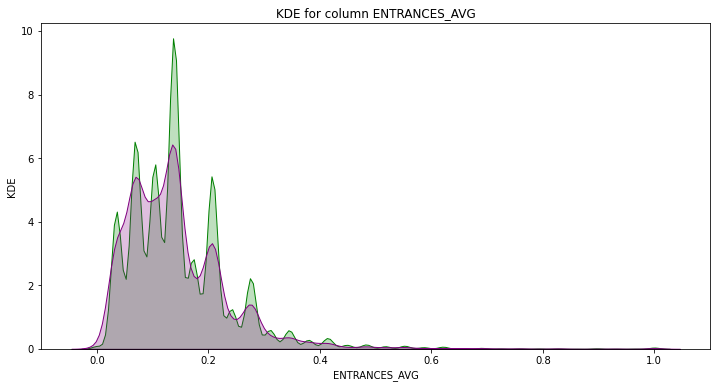

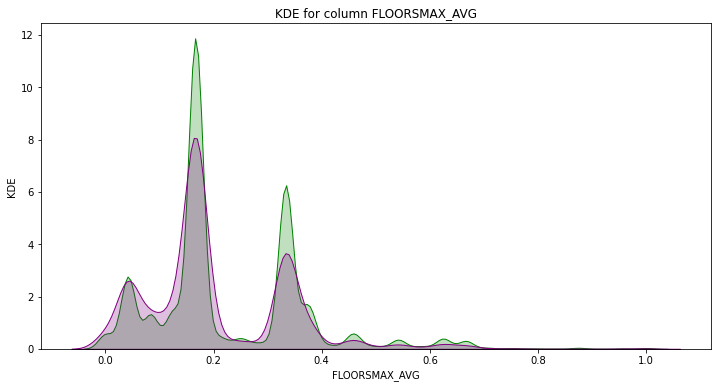

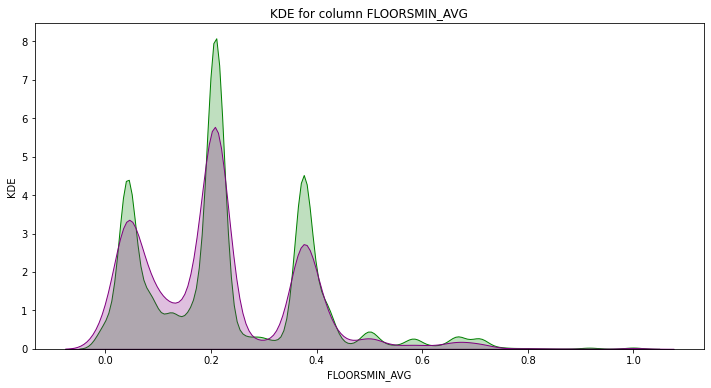

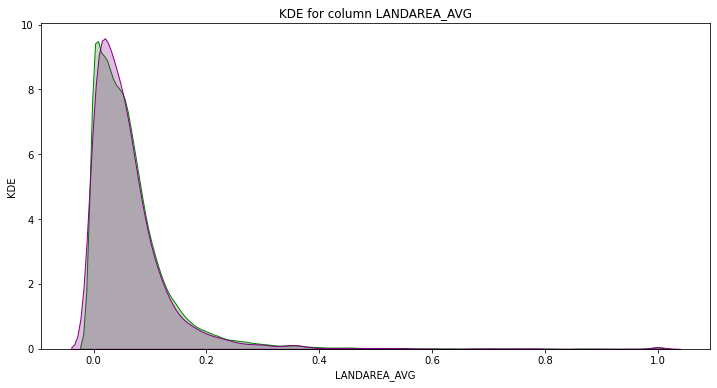

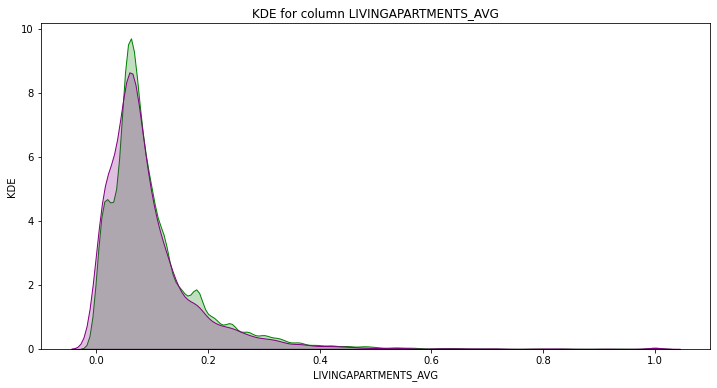

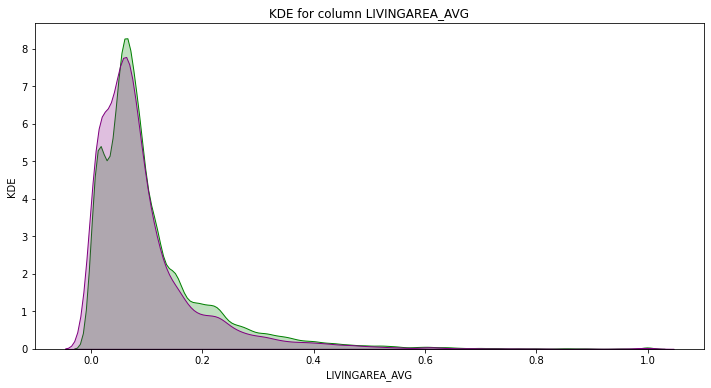

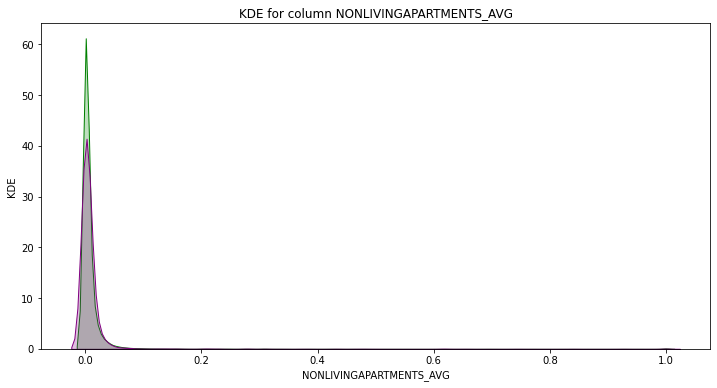

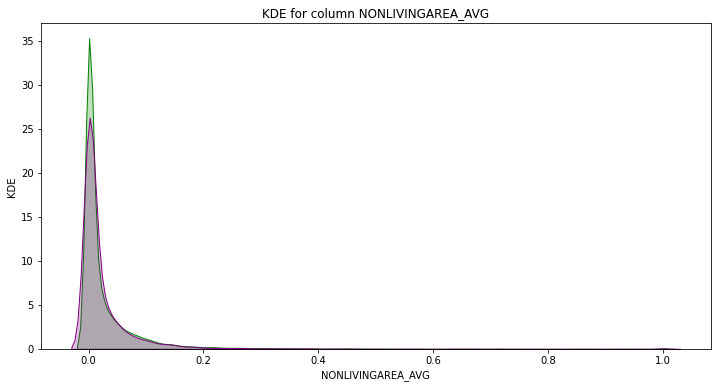

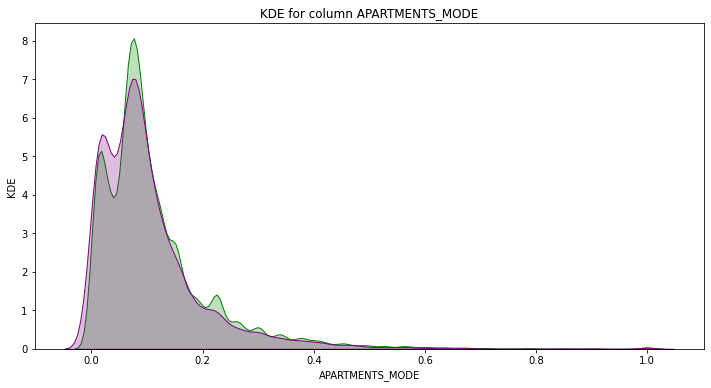

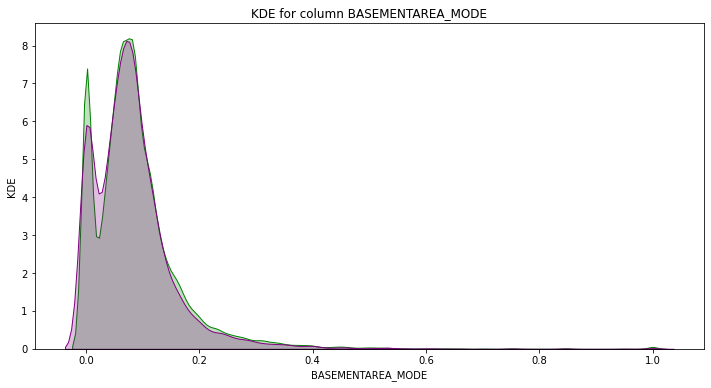

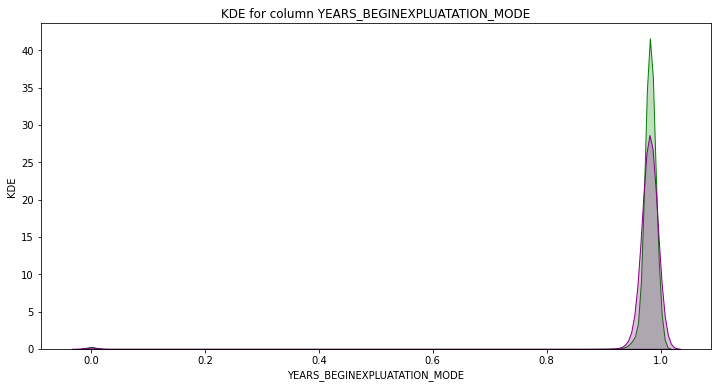

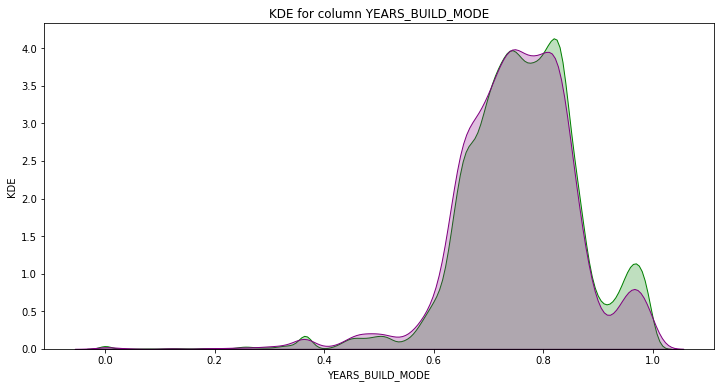

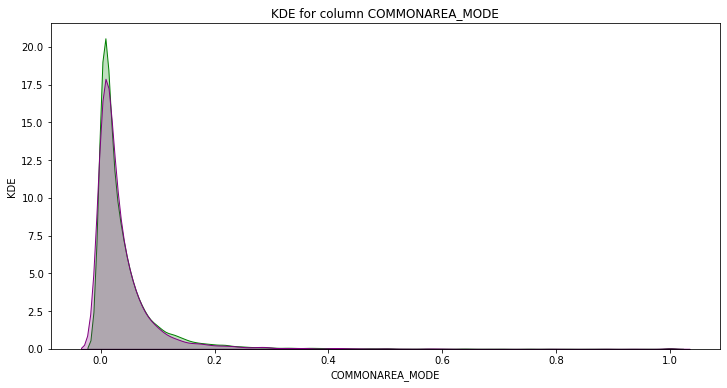

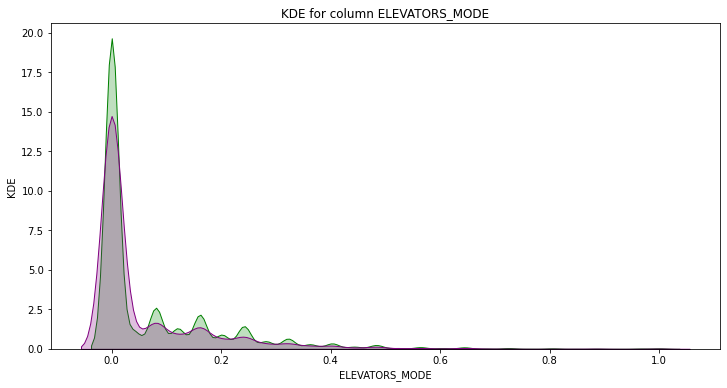

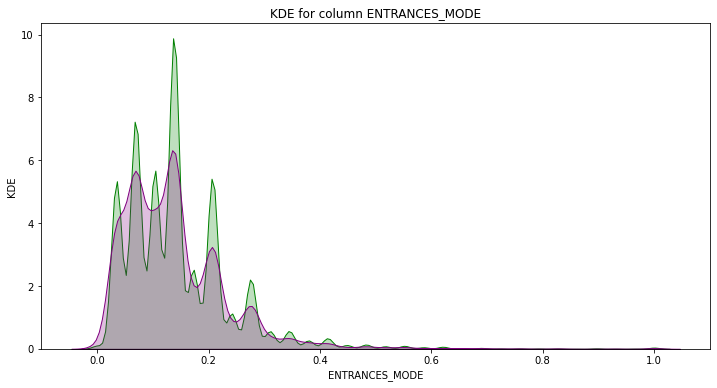

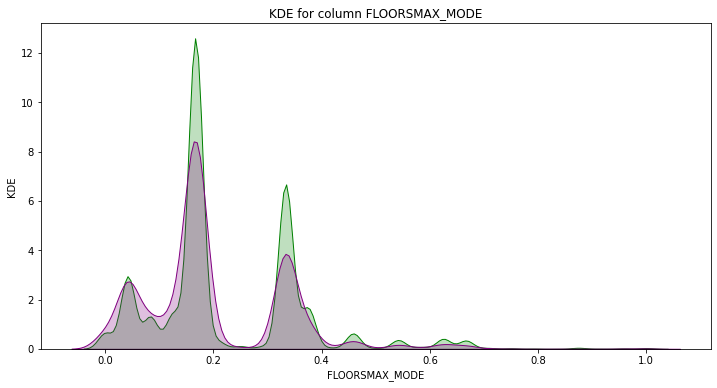

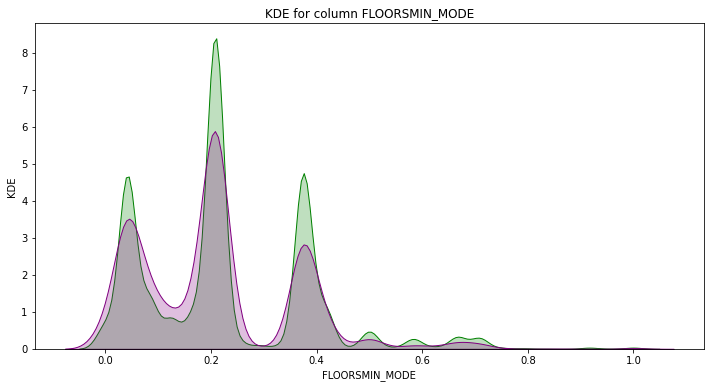

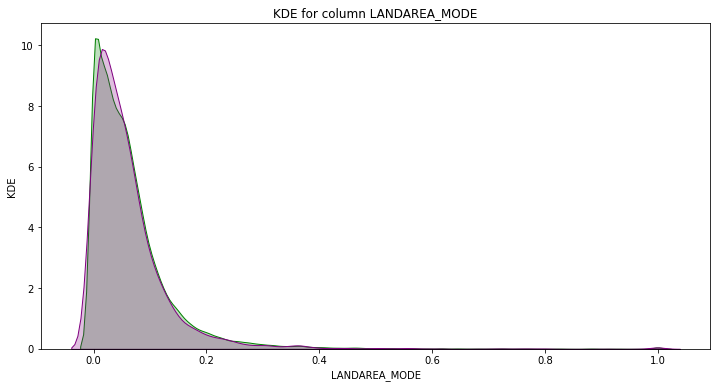

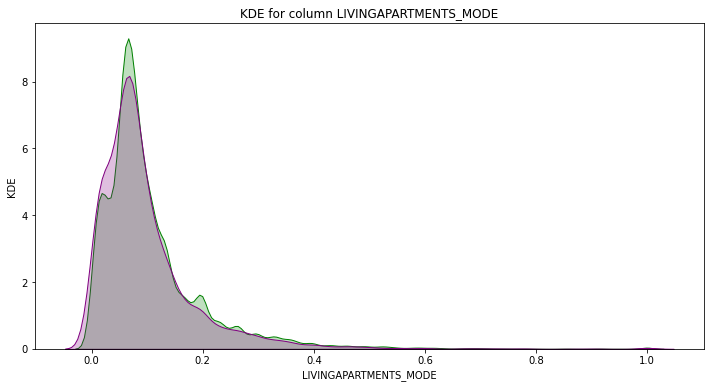

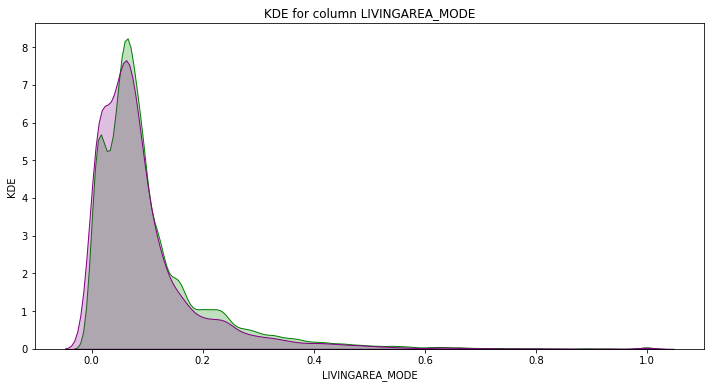

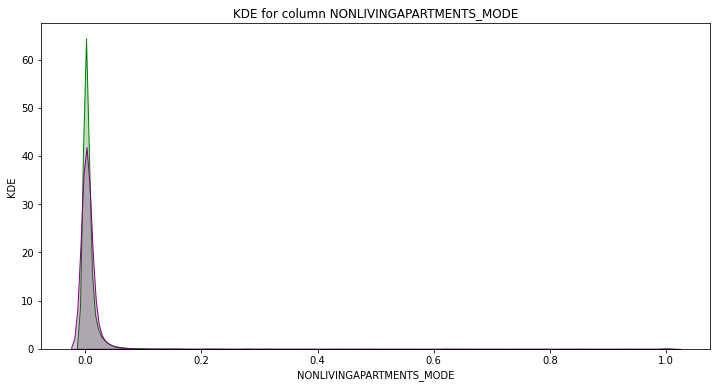

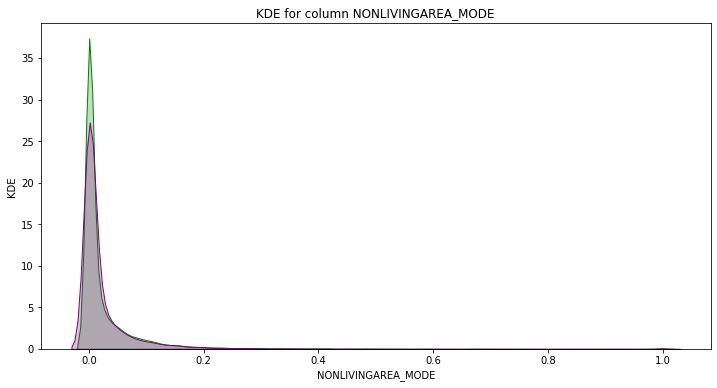

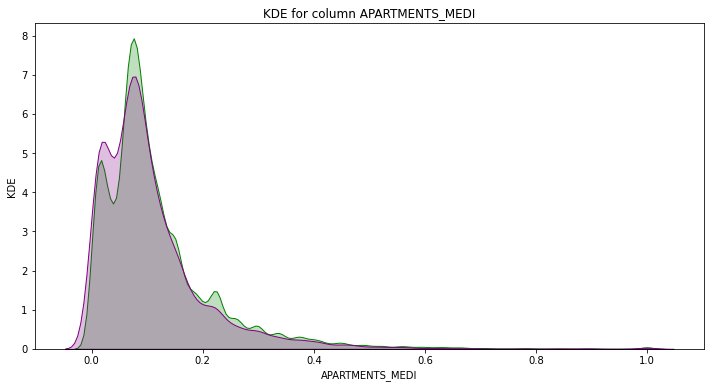

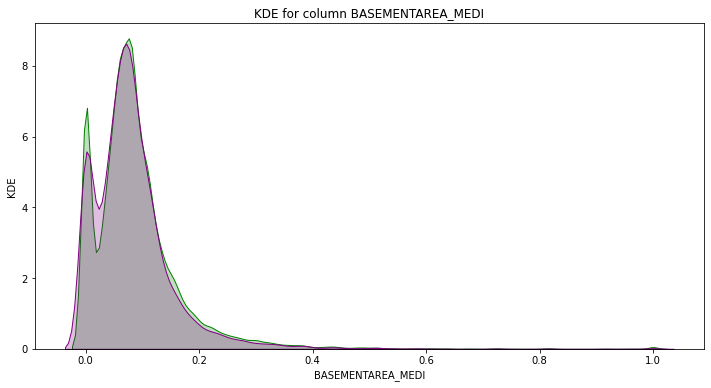

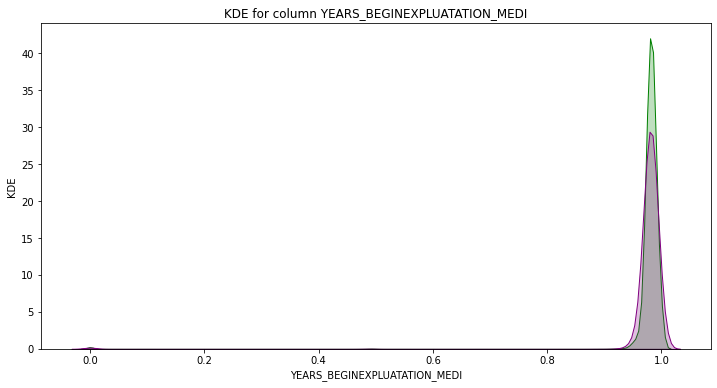

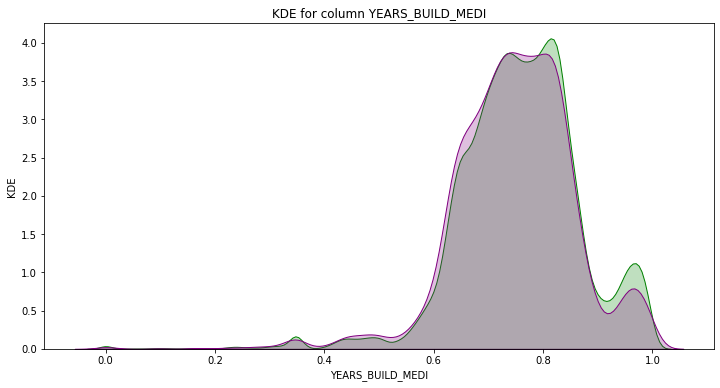

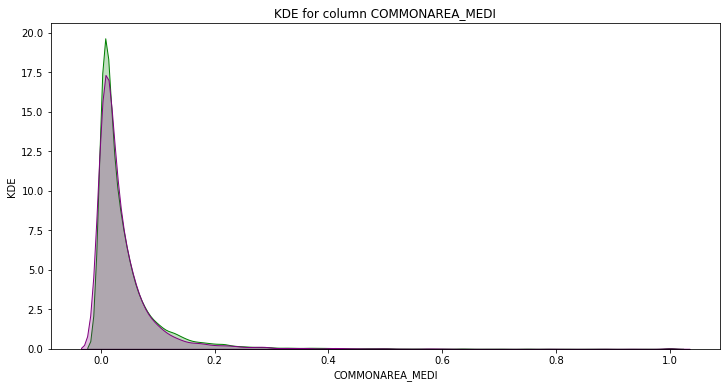

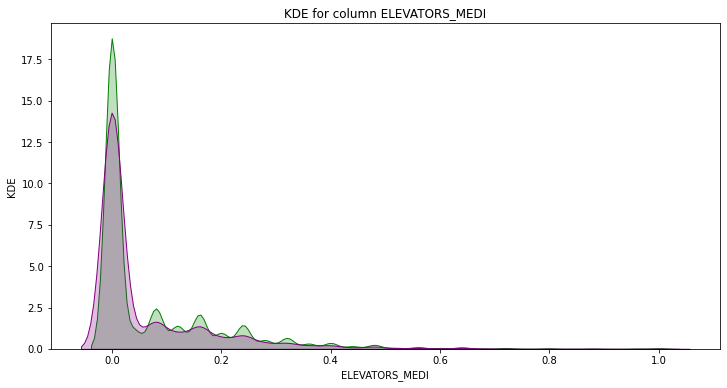

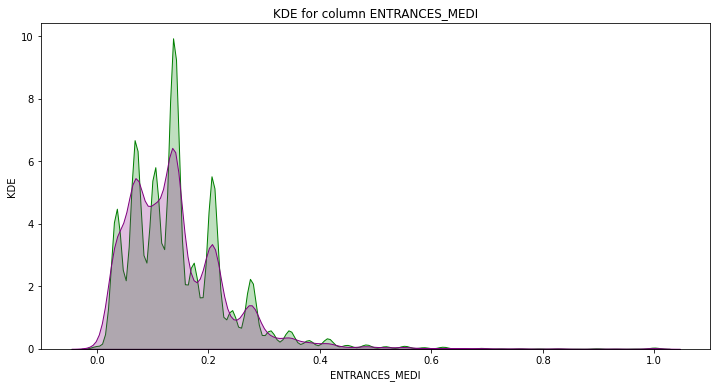

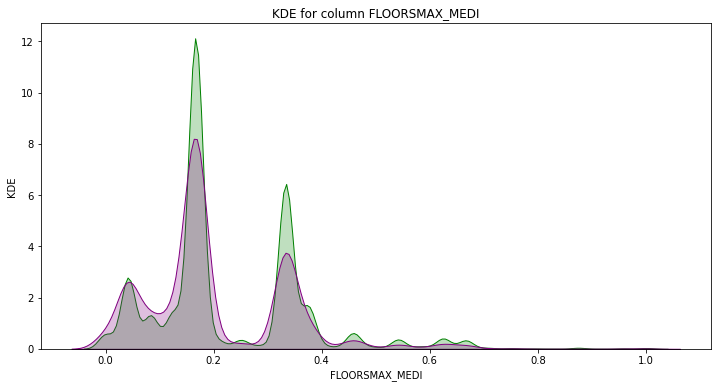

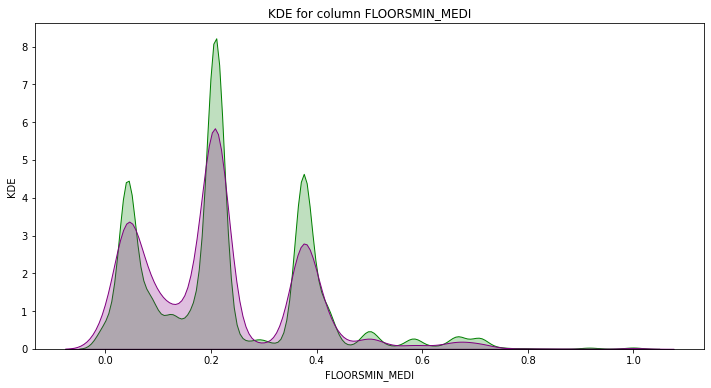

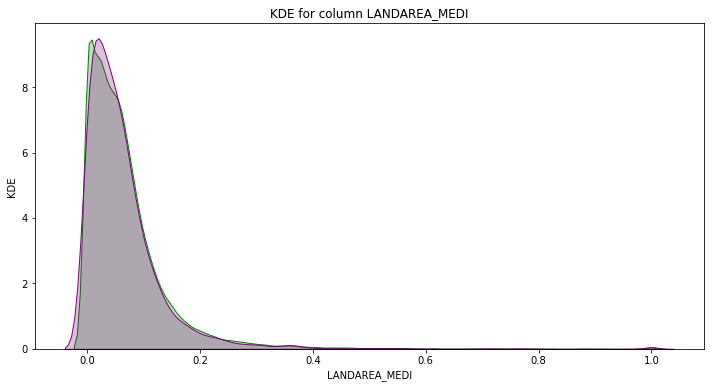

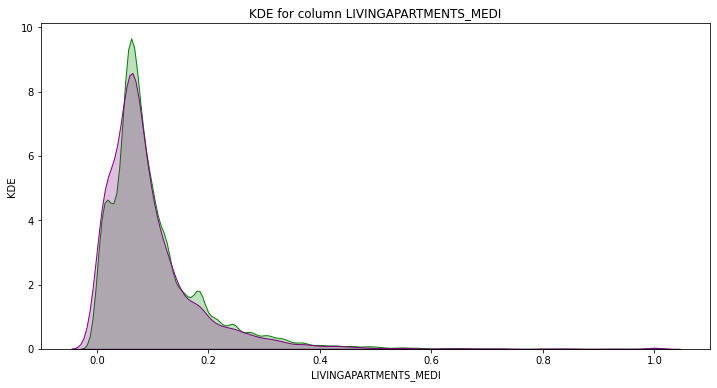

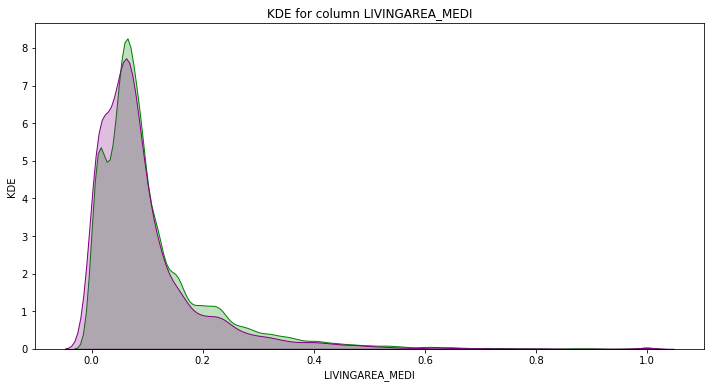

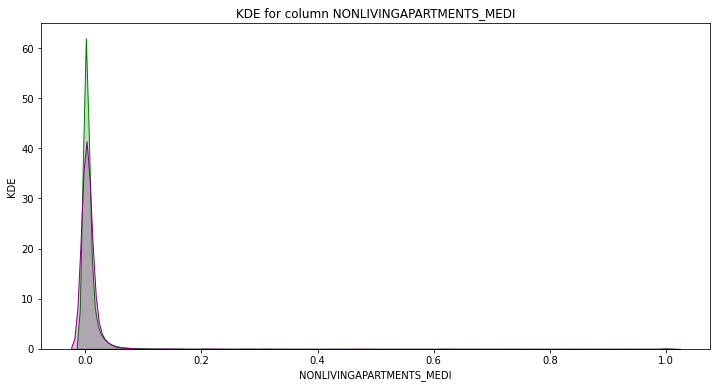

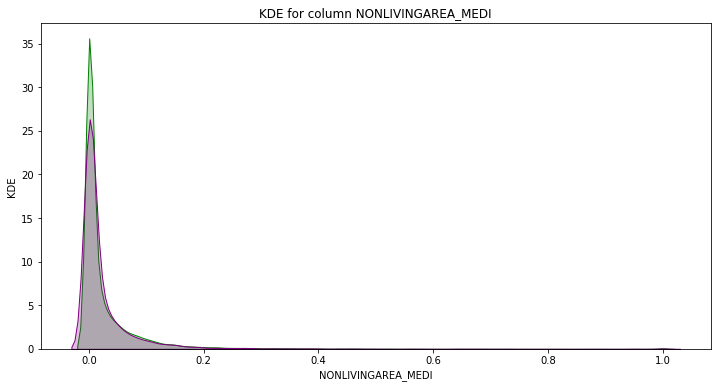

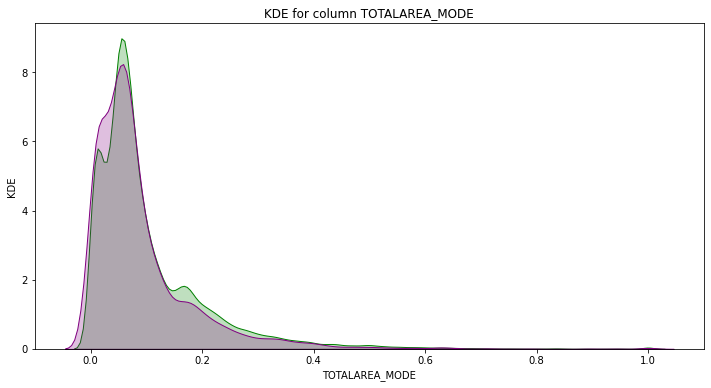

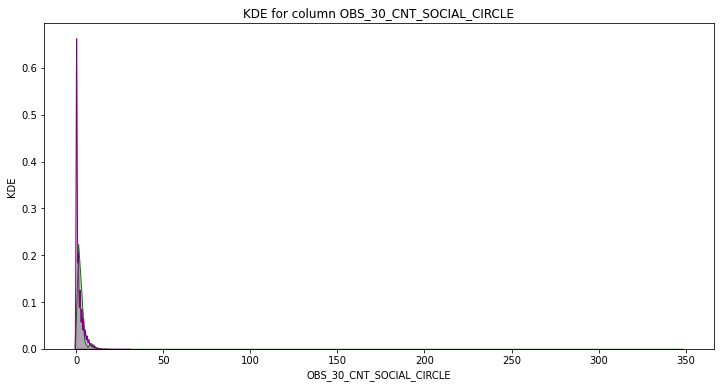

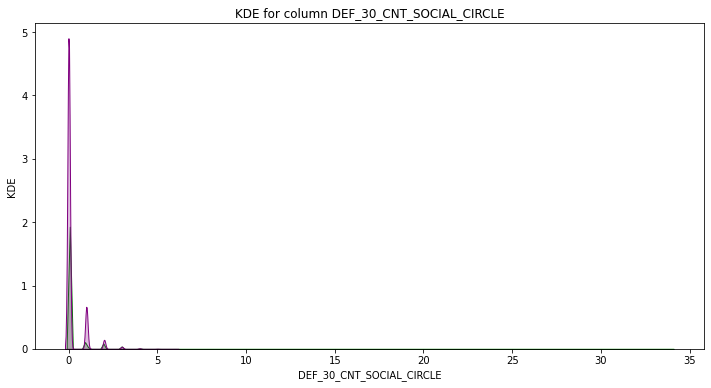

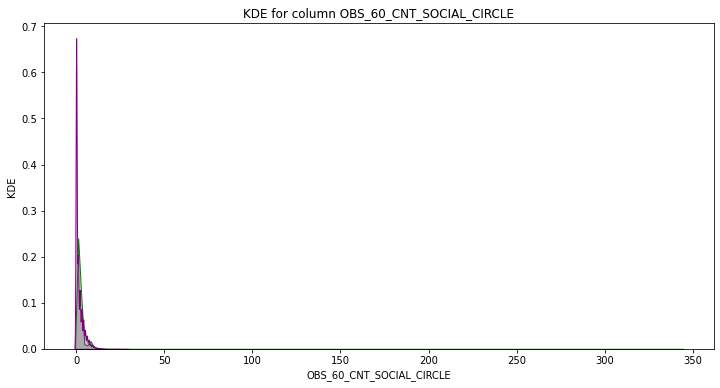

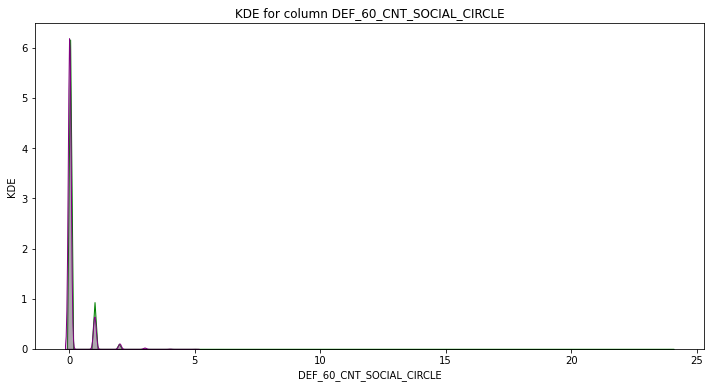

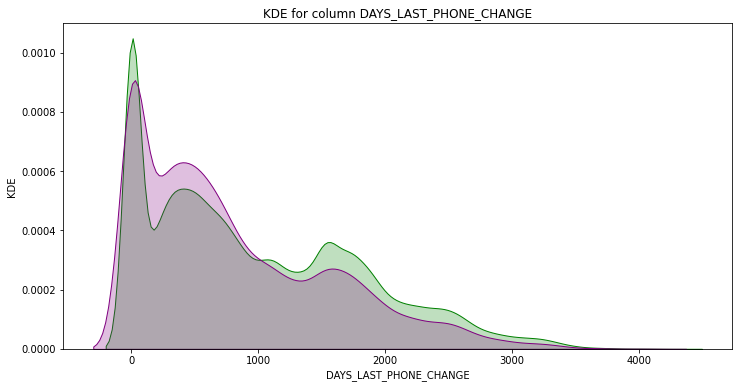

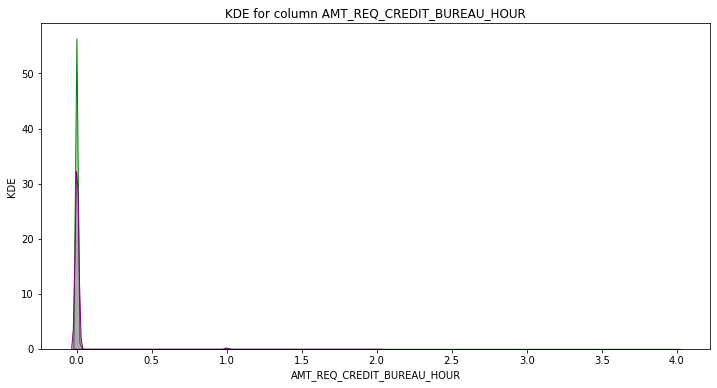

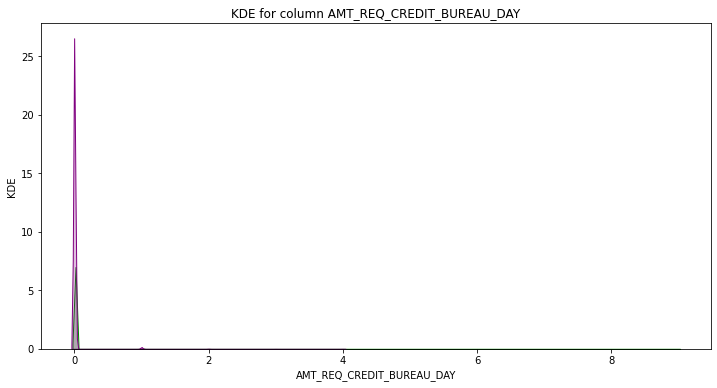

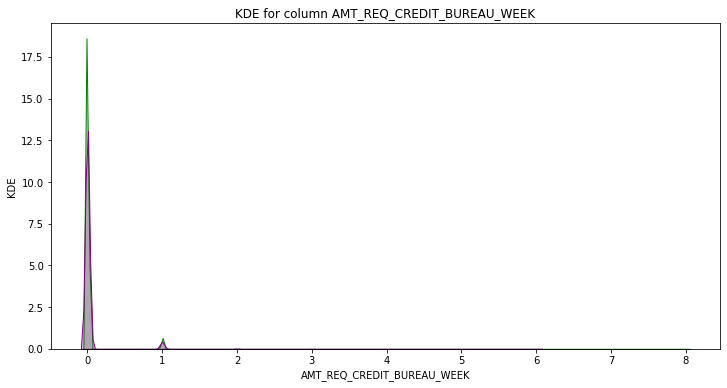

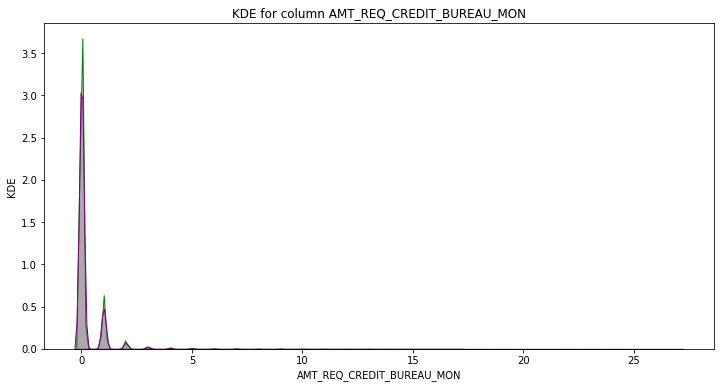

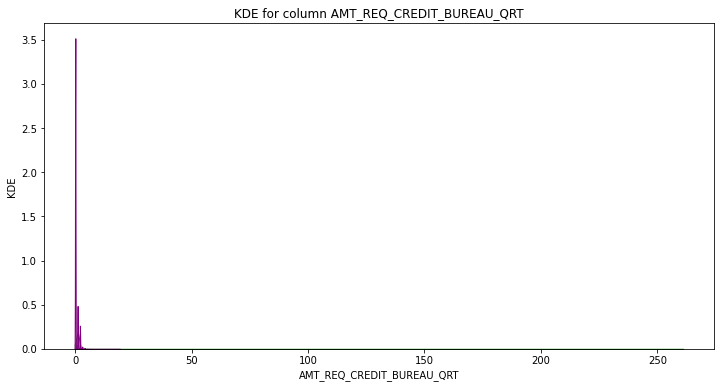

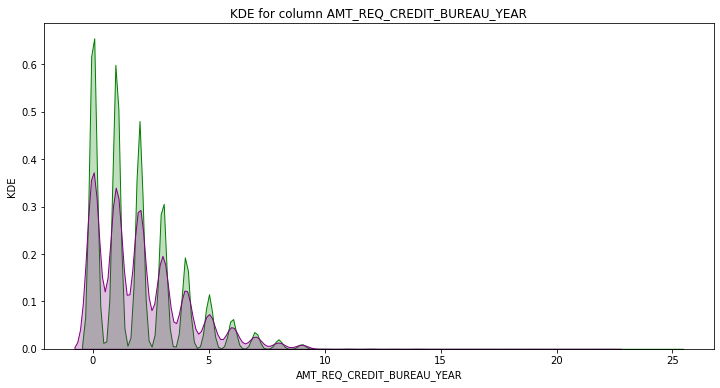

In [13]:
# iterate over all float (continuous) variables and plot KDE
for col in train.loc[:, (train.dtypes == np.float64)].columns.values:
    # reverse axis if values are negative
    if (train[col].median() < 0):
        functions.plot_kde(train, col, 'TARGET', reverse_scale = True)
    else:
        functions.plot_kde(train,col, 'TARGET')

## Correction des anomalies

<AxesSubplot:>

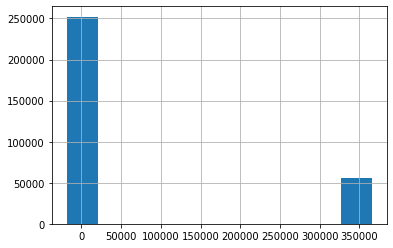

In [14]:
train.DAYS_EMPLOYED.hist()

La colonne 'DAYS_EMPLOYED' comporte des données incohérentes que nous allons remplacer la médiane

In [15]:
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    
train.drop(columns='DAYS_EMPLOYED_ANOM', inplace=True)
test.drop(columns='DAYS_EMPLOYED_ANOM', inplace=True)

<AxesSubplot:>

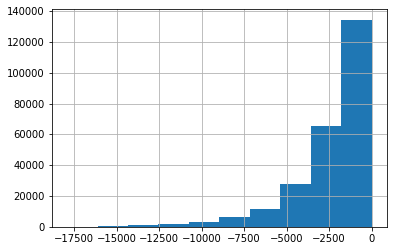

In [16]:
train.DAYS_EMPLOYED.hist()

## Visualisation de la colonne TARGET

0    282686
1     24825
Name: TARGET, dtype: int64


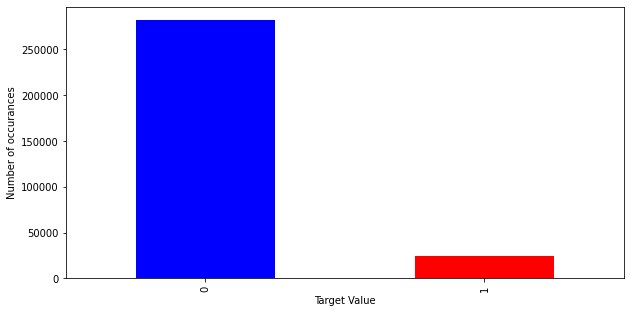

In [17]:
print(train['TARGET'].value_counts())
train['TARGET'].value_counts().plot(kind='bar', figsize=(10,5), color = ['blue', 'red'])
plt.xlabel('Target Value')
plt.ylabel('Number of occurances') 
plt.show()

Le dataset est fortement déséquilibré, il y a 10 fois plus de valeurs 0 que de valeurs 1 pour la variable 'TARGET'. Il est donc nécessaire d'effectuer un rééquilibrage.

## Corrélations

In [18]:
correlations = train.corr()['TARGET'].sort_values()

Meilleures corrélations positives

In [19]:
correlations.sort_values(ascending=False).head(16)

TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
Name: TA

Meilleures corrélations négatives

In [20]:
correlations.sort_values(ascending=True).head(16)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
Name: TARGET, dtype: float64

Nous allons conserver uniquement ces variables pour l'entraînement de nos modèles.

In [21]:
corr_pos = list(correlations.sort_values(ascending=False).head(16).index)
corr_neg = list(correlations.sort_values(ascending=True).head(16).index)
corr = corr_pos + corr_neg

In [22]:
corr

['TARGET',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_Working',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'OCCUPATION_TYPE_Laborers',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'EMERGENCYSTATE_MODE_No',
 'HOUSETYPE_MODE_block of flats',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI']

On crée un nouveau dataframeà partir de ces variables.

In [23]:
df = train[corr]

In [24]:
sample = df.copy()

In [25]:
df

TARGET  DAYS_BIRTH  DAYS_EMPLOYED  REGION_RATING_CLIENT_W_CITY  \
0            1       -9461         -637.0                            2   
1            0      -16765        -1188.0                            1   
2            0      -19046         -225.0                            2   
3            0      -19005        -3039.0                            2   
4            0      -19932        -3038.0                            2   
...        ...         ...            ...                          ...   
307506       0       -9327         -236.0                            1   
307507       0      -20775            NaN                            2   
307508       0      -14966        -7921.0                            3   
307509       1      -11961        -4786.0                            2   
307510       0      -16856        -1262.0                            1   

        REGION_RATING_CLIENT  NAME_INCOME_TYPE_Working  \
0                          2                         1   
1                          1                         0   
2                          2                         1   
3                          2                         1   
4                          2                         1   
...                      ...                       ...   
307506                     1                         1   
307507                     2                         0   
307508                     3                         1   
307509                     2                         0   
307510                     1                         0   

        DAYS_LAST_PHONE_CHANGE  CODE_GENDER_M  DAYS_ID_PUBLISH  \
0                      -1134.0              1            -2120   
1                       -828.0              0             -291   
2                       -815.0              1            -2531   
3                       -617.0              0            -2437   
4                      -1106.0              1            -3458   
...                        ...            ...              ...   
307506                  -273.0              1            -1982   
307507                     0.0              0            -4090   
307508                 -1909.0              0            -5150   
307509                  -322.0              0             -931   
307510                  -787.0              0             -410   

        REG_CITY_NOT_WORK_CITY  ...  ORGANIZATION_TYPE_XNA  FLOORSMAX_AVG  \
0                            0  ...                      0         0.0833   
1                            0  ...                      0         0.2917   
2                            0  ...                      0            NaN   
3                            0  ...                      0            NaN   
4                            1  ...                      0            NaN   
...                        ...  ...                    ...            ...   
307506                       0  ...                      0         0.6042   
307507                       0  ...                      1         0.0833   
307508                       1  ...                      0         0.1667   
307509                       1  ...                      0         0.0417   
307510                       1  ...                      0         0.3750   

        FLOORSMAX_MEDI  FLOORSMAX_MODE  EMERGENCYSTATE_MODE_No  \
0               0.0833          0.0833                       1   
1               0.2917          0.2917                       1   
2                  NaN             NaN                       0   
3                  NaN             NaN                       0   
4                  NaN             NaN                       0   
...                ...             ...                     ...   
307506          0.6042          0.4583                       1   
307507          0.0833          0.0833                       1   
307508          0.1667          0.1667                       1   
307509          0.0417          0.0417      

In [26]:
test

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100001                   0             0                1   
1          100005                   0             0                1   
2          100013                   0             1                1   
3          100028                   0             0                1   
4          100038                   0             1                0   
...           ...                 ...           ...              ...   
48739      456221                   0             0                1   
48740      456222                   0             0                0   
48741      456223                   0             1                1   
48742      456224                   0             0                0   
48743      456250                   0             1                0   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...  \
0             450000.0                    0.018850  ...   
1             180000.0                    0.035792  ...   
2             630000.0                    0.019101  ...   
3            1575000.0                    0.026392  ...   
4             625500.0                    0.010032  ...   
...                ...                         ...  ...   
48739         270000.0                    0.002042  ...   
48740         495000.0                    0.035792  ...   
48741         315000.0                    0.026392  ...   
48742         450000.0                    0.018850  ...   
48743         270000.0                    0.006629  ...   

       HOUSETYPE_MODE_terraced house  WALLSMATERIAL_MODE_Block  \
0                                  0                         0   
1                                  0                         0   
2                                  0                         0   
3                                  0                         0   
4                                  0                         0   
...                              ...                       ...   
48739                              0                         0   
48740                              0                         0   
48741                              0                         0   
48742                              0                         0   
48743                              0                         0   

       WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                             0                              0   
1                             0                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   
...                         ...                            ...   
48739                         0                              0   
48740                         0                              0   
48741                         0                              0   
48742                         0                              0   
48743                         0                              0   

       WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_P

## Création de nos bases de test et de train

In [27]:
df.head(1000).to_csv('../csv_files/d_head.csv')

In [28]:
df.dropna(inplace=True)

In [29]:
# create X_train, y_train
X_train = df.drop('TARGET', axis = 1)
y_train = df['TARGET']
X_test = test[corr[1:]]
target = y_train
# Feature names
features_list = list(X_train.columns)

In [30]:
X_test

DAYS_BIRTH  DAYS_EMPLOYED  REGION_RATING_CLIENT_W_CITY  \
0          -19241        -2329.0                            2   
1          -18064        -4469.0                            2   
2          -20038        -4458.0                            2   
3          -13976        -1866.0                            2   
4          -13040        -2191.0                            2   
...           ...            ...                          ...   
48739      -19970        -5169.0                            3   
48740      -11186        -1149.0                            2   
48741      -15922        -3037.0                            2   
48742      -13968        -2731.0                            2   
48743      -13962         -633.0                            2   

       REGION_RATING_CLIENT  NAME_INCOME_TYPE_Working  DAYS_LAST_PHONE_CHANGE  \
0                         2                         1                 -1740.0   
1                         2                         1                     0.0   
2                         2                         1                  -856.0   
3                         2                         1                 -1805.0   
4                         2                         1                  -821.0   
...                     ...                       ...                     ...   
48739                     3                         1                  -684.0   
48740                     2                         0                     0.0   
48741                     2                         0                  -838.0   
48742                     2                         0                 -2308.0   
48743                     2                         1                  -327.0   

       CODE_GENDER_M  DAYS_ID_PUBLISH  REG_CITY_NOT_WORK_CITY  \
0                  0             -812                       0   
1                  1            -1623                       0   
2                  1            -3503                       0   
3                  0            -4208                       0   
4                  1            -4262                       1   
...              ...              ...                     ...   
48739              0            -3399                       0   
48740              0            -3003                       1   
48741              0            -1504                       0   
48742              1            -1364                       1   
48743              0            -4220                       0   

       NAME_EDUCATION_TYPE_Secondary / secondary special  ...  \
0                                                      0  ...   
1                                                      1  ...   
2                                                      0  ...   
3                                                      1  ...   
4                                                      1  ...   
...                                                  ...  ...   
48739                                                  1  ...   
48740                                                  1  ...   
48741                                                  1  ...   
48742                                                  0  ...   
48743                                                  1  ...   

       ORGANIZATION_TYPE_XNA  FLOORSMAX_AVG  FLOORSMAX_MEDI  FLOORSMAX_MODE  \
0                          0         0.1250          0.1250          0.1250   
1                          0            NaN             NaN             NaN   
2                          0            NaN             NaN             NaN   
3                          0         0.3750          0.3750          0.3750   
4                          0            NaN             NaN             NaN   
...                      ...            ...             ...             ...   
48739                      0            NaN             NaN             NaN   
48740                      0            NaN             NaN

### Imputer

In [31]:
#Impute missing values using median strategy
imputer = SimpleImputer(strategy = 'median')

#Scale all values in 0-1 range
scaler = MinMaxScaler(feature_range = (0, 1))

#fit the imputer on training set
imputer.fit(X_train)

#transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

#fit scaler and transform
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

In [32]:
test

array([[0.33316029, 0.8588057 , 0.5       , ..., 0.25699964, 0.        ,
        0.        ],
       [0.40104978, 0.72906941, 0.5       , ..., 0.49159489, 0.        ,
        0.        ],
       [0.28718925, 0.72973628, 0.5       , ..., 0.26047523, 0.        ,
        0.        ],
       ...,
       [0.52460057, 0.8158836 , 0.5       , ..., 0.36143344, 0.16      ,
        0.16      ],
       [0.63730749, 0.83443468, 0.5       , ..., 0.25699964, 0.16      ,
        0.16      ],
       [0.63765357, 0.96162473, 0.5       , ..., 0.0877759 , 0.        ,
        0.        ]])

## Validation du choix des modèles

In [33]:
my_scorer = make_scorer(fbeta_score, beta=3)

In [34]:
lgbm_model = lgbm.LGBMClassifier(random_state = 42)

ridge_model = RidgeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [35]:
#scoring the lgbm model
scores = cross_val_score(lgbm_model, train, target, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.014 (0.007)


In [36]:
#scoring the ridge model
scores = cross_val_score(ridge_model, train, target, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.000 (0.000)


In [37]:
#scoring the ridge model
scores = cross_val_score(random_forest, train, target, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.003 (0.003)


Du point de vue du score FB, le modèle LGBM est nettement supérieur.

## Entraînement des modèles

In [38]:
train_features, test_features, train_labels, test_labels = train_test_split(train, target, test_size = 0.2, random_state = 42)

In [39]:
lgbm_model.fit(train_features, train_labels)
ridge_model.fit(train_features, train_labels)
random_forest.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [40]:
lgbm_predictions = lgbm_model.predict(test_features)
ridge_predictions = ridge_model.predict(test_features)
rf_predictions = random_forest.predict(test_features)

In [41]:
#let's get the scores
def get_scores (preds): 
    print('Accuracy: %.3f' % accuracy_score(test_labels.values, preds))
    print('Precision: %.3f' % precision_score(test_labels.values, preds))
    print('Recall: %.3f' % recall_score(test_labels.values, preds))
    print('F1: %.3f' % f1_score(test_labels.values, preds))
    print('FB: %.3f' % fbeta_score(test_labels.values, preds, beta=3), '\n')
print('LGBM scores : ')
get_scores(lgbm_predictions)
print('Ridge scores : ')
get_scores(ridge_predictions)
print('Random Forest scores : ')
get_scores(rf_predictions)

LGBM scores : 
Accuracy: 0.934
Precision: 0.182
Recall: 0.010
F1: 0.018
FB: 0.011 

Ridge scores : 
Accuracy: 0.936
Precision: 0.000
Recall: 0.000
F1: 0.000
FB: 0.000 

Random Forest scores : 
Accuracy: 0.936
Precision: 0.429
Recall: 0.005
F1: 0.010
FB: 0.005 



Malgré une accuracy très élevée, les modèles ont du mal à prédire efficacement, comme le montre les autres scores très faibles. Ceci est du au fait que le dataset est fortement déséquilibré.

LGBM confusion matrix : 


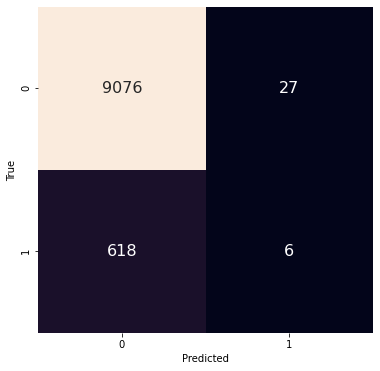

Ridge confusion matrix : 


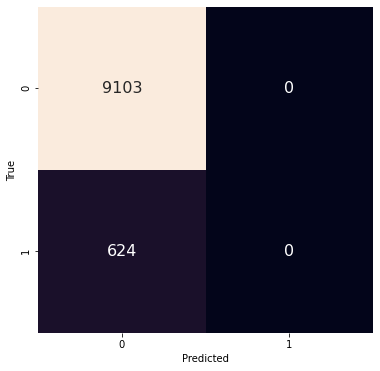

Random Forest confusion matrix : 


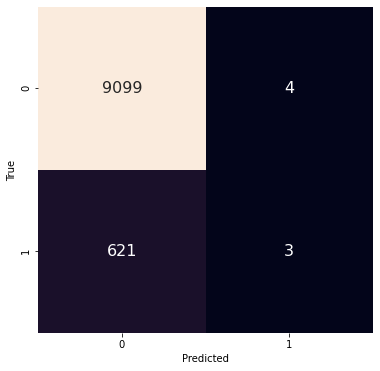

In [42]:
def my_confusion_matrix(predictions):
    con_mat = confusion_matrix(test_labels.values, predictions)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(6,6))
    #sns.set(font_scale=1.5) 
    sns.heatmap(con_mat,annot=True, cbar=False, annot_kws={"size": 16}, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

 



print('LGBM confusion matrix : ')
my_confusion_matrix(lgbm_predictions)
print('Ridge confusion matrix : ')
my_confusion_matrix(ridge_predictions)
print('Random Forest confusion matrix : ')
my_confusion_matrix(rf_predictions)

Nous allons nous atteler à rééquilibrer artificiellement le dataset afin d'augmenetr le f-beta score.

## Under-sampling

In [43]:
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(train_features, train_labels)

In [44]:
print(X_resampled.shape)
print(y_resampled.shape)
print(train_features.shape)
print(train_labels.shape)

(5112, 31)
(5112,)
(38906, 31)
(38906,)


In [45]:
print(Counter(train_labels))
print(Counter(y_resampled))

Counter({0: 36350, 1: 2556})
Counter({0: 2556, 1: 2556})


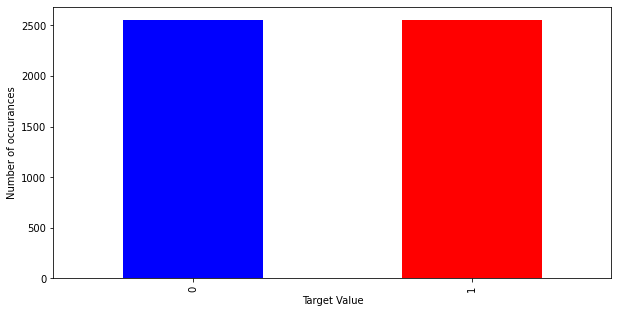

In [46]:
y_resampled.value_counts()
y_resampled.value_counts().plot(kind='bar', figsize=(10,5), color = ['blue', 'red'])
plt.xlabel('Target Value')
plt.ylabel('Number of occurances') 
plt.show()

Le jeu de données est maintenant équilibré, nous avons effecuté un under-sampling pour réduire le nombre de 0 de la variable 'TARGET' et faire en sorte qu'il soit égal au nombre de 1.

## Model

In [47]:
lgbm_model = lgbm.LGBMClassifier(random_state = 42)#, class_weight='balanced')

ridge_model = RidgeClassifier(random_state=42)#,  class_weight='balanced')

random_forest = RandomForestClassifier(random_state=42)#,  class_weight='balanced')

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [48]:
#scoring the lgbm model
scores = cross_val_score(lgbm_model, X_resampled, y_resampled, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.678 (0.022)


In [49]:
#scoring the ridge model
scores = cross_val_score(ridge_model, X_resampled, y_resampled, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.686 (0.025)


In [50]:
#scoring the ridge model
scores = cross_val_score(random_forest, X_resampled, y_resampled, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.667 (0.023)


## Entraînement des modèles

In [51]:
lgbm_model.fit(X_resampled, y_resampled, )
ridge_model.fit(X_resampled, y_resampled)
random_forest.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [52]:
lgbm_predictions = lgbm_model.predict(test_features)
ridge_predictions = ridge_model.predict(test_features)
rf_predictions = random_forest.predict(test_features)

In [53]:
print('LGBM scores : ')
get_scores(lgbm_predictions)
print('Ridge scores : ')
get_scores(ridge_predictions)
print('Random Forest scores : ')
get_scores(rf_predictions)

LGBM scores : 
Accuracy: 0.680
Precision: 0.125
Recall: 0.665
F1: 0.210
FB: 0.464 

Ridge scores : 
Accuracy: 0.690
Precision: 0.130
Recall: 0.676
F1: 0.219
FB: 0.477 

Random Forest scores : 
Accuracy: 0.690
Precision: 0.127
Recall: 0.654
F1: 0.213
FB: 0.462 



Du point de vue du score FB ces trois modèles sont équivalents. Ridge semble légèrement plus performant.

In [54]:
tn, fp, fn, tp = confusion_matrix(test_labels.values, lgbm_predictions).ravel()

In [55]:
tn, fp, fn, tp

(6196, 2907, 209, 415)

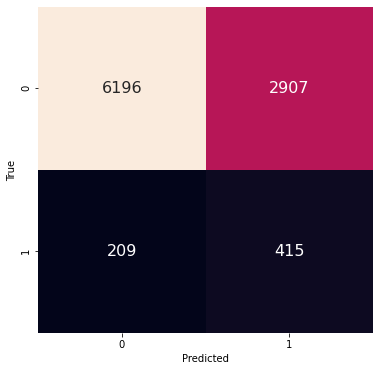

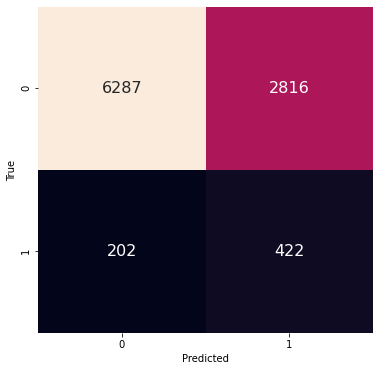

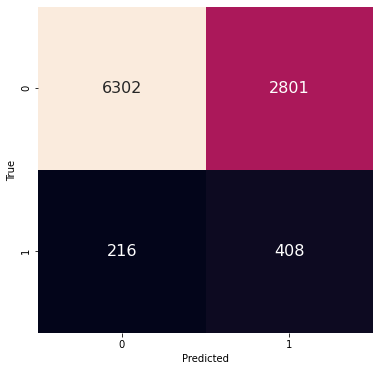

In [56]:
def my_confusion_matrix(predictions):
    con_mat = confusion_matrix(test_labels.values, predictions)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(6,6))
    #sns.set(font_scale=1.5) 
    sns.heatmap(con_mat,annot=True, cbar=False, annot_kws={"size": 16}, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    

    
my_confusion_matrix(lgbm_predictions)
my_confusion_matrix(ridge_predictions)
my_confusion_matrix(rf_predictions)

## CLASS WEIGHT

Nous etstons ici une nouvelle méthode pour prendre en compte le déséquilibre du dataset en utilisant l'argument class_weight des modèles.

In [57]:
lgbm_model = lgbm.LGBMClassifier(random_state = 42, class_weight='balanced', )

ridge_model = RidgeClassifier(random_state=42, class_weight='balanced')

random_forest = RandomForestClassifier(random_state=42, class_weight='balanced')

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [58]:
#scoring the lgbm model
scores = cross_val_score(lgbm_model, train_features, train_labels, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.452 (0.023)


In [59]:
#scoring the ridge model
scores = cross_val_score(ridge_model, train_features, train_labels, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.487 (0.019)


In [60]:
#scoring the random forest model
scores = cross_val_score(random_forest, train_features, train_labels, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.003 (0.003)


## Entraînement des modèles

In [61]:
lgbm_model.fit(train_features, train_labels)
ridge_model.fit(train_features, train_labels)
random_forest.fit(train_features, train_labels)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [62]:
lgbm_predictions = lgbm_model.predict(test_features)
ridge_predictions = ridge_model.predict(test_features)
rf_predictions = random_forest.predict(test_features)

In [63]:
print('LGBM scores : ')
get_scores(lgbm_predictions)
print('Ridge scores : ')
get_scores(ridge_predictions)
print('Random Forest scores : ')
get_scores(rf_predictions)

LGBM scores : 
Accuracy: 0.764
Precision: 0.150
Recall: 0.574
F1: 0.237
FB: 0.447 

Ridge scores : 
Accuracy: 0.691
Precision: 0.132
Recall: 0.684
F1: 0.221
FB: 0.482 

Random Forest scores : 
Accuracy: 0.936
Precision: 1.000
Recall: 0.002
F1: 0.003
FB: 0.002 



Encore une fois, Ridge est plus performant.

In [64]:
tn, fp, fn, tp = confusion_matrix(test_labels.values, lgbm_predictions).ravel()

In [65]:
tn, fp, fn, tp

(7069, 2034, 266, 358)

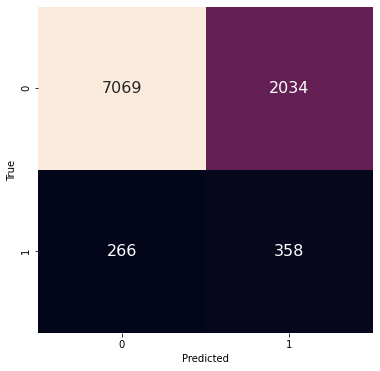

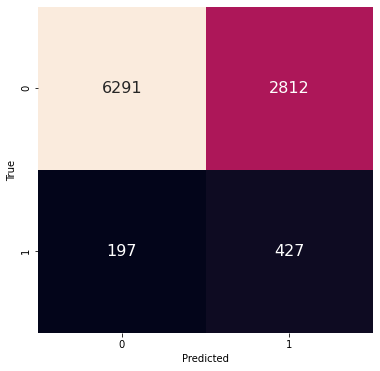

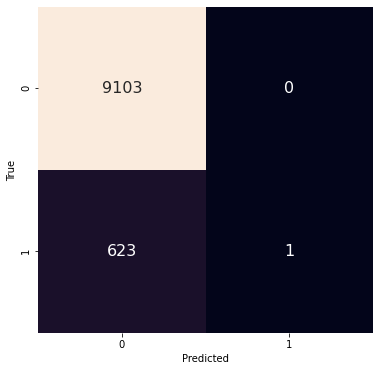

In [66]:
def my_confusion_matrix(predictions):
    con_mat = confusion_matrix(test_labels.values, predictions)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(6,6))
    #sns.set(font_scale=1.5) 
    sns.heatmap(con_mat,annot=True, cbar=False, annot_kws={"size": 16}, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    

    
my_confusion_matrix(lgbm_predictions)
my_confusion_matrix(ridge_predictions)
my_confusion_matrix(rf_predictions)

## SMOTE

Nouvelle méthode d'équilibrage, on effectue un over-sampling.

In [67]:
from imblearn.over_sampling import SMOTE

In [68]:
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(train_features, train_labels)

In [69]:
print(X_smote.shape)
print(y_smote.shape)
print(train_features.shape)
print(train_labels.shape)

(72700, 31)
(72700,)
(38906, 31)
(38906,)


In [70]:
print(Counter(train_labels))
print(Counter(y_smote))

Counter({0: 36350, 1: 2556})
Counter({0: 36350, 1: 36350})


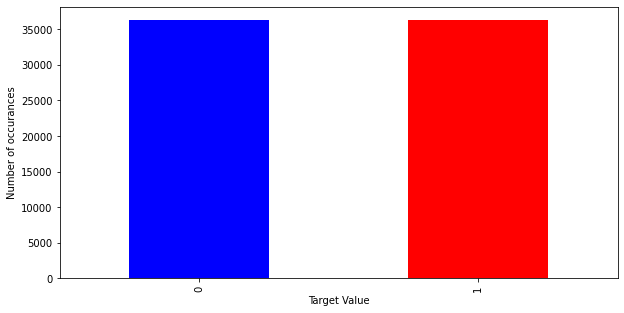

In [71]:
y_smote.value_counts()
y_smote.value_counts().plot(kind='bar', figsize=(10,5), color = ['blue', 'red'])
plt.xlabel('Target Value')
plt.ylabel('Number of occurances') 
plt.show()

Le jeu de données est maintenant équilibré, nous avons effecuté un over-sampling pour augmenter le nombre de 1 de la variable 'TARGET' et faire en sorte qu'il soit égal au nombre de 0.

## Model

In [72]:
my_scorer

make_scorer(fbeta_score, beta=3)

In [73]:
lgbm_model = lgbm.LGBMClassifier(random_state = 42)

ridge_model = RidgeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [74]:
#scoring the lgbm model
scores = cross_val_score(lgbm_model, X_smote, y_smote, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.912 (0.004)


In [75]:
#scoring the ridge model
scores = cross_val_score(ridge_model, X_smote, y_smote, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.708 (0.006)


In [76]:
#scoring the random forest model
scores = cross_val_score(random_forest, X_smote, y_smote, scoring=my_scorer, cv=cv, n_jobs=-1)
print('Mean FB: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean FB: 0.951 (0.003)


## Entraînement des modèles

In [77]:
lgbm_model.fit(X_smote, y_smote)
ridge_model.fit(X_smote, y_smote)
random_forest.fit(X_smote, y_smote)

RandomForestClassifier(random_state=42)

In [78]:
lgbm_predictions = lgbm_model.predict(test_features)
ridge_predictions = ridge_model.predict(test_features)
rf_predictions = random_forest.predict(test_features)

In [79]:
print('LGBM scores : ')
get_scores(lgbm_predictions)
print('Ridge scores : ')
get_scores(ridge_predictions)
print('Random Forest scores : ')
get_scores(rf_predictions)

LGBM scores : 
Accuracy: 0.912
Precision: 0.188
Recall: 0.111
F1: 0.139
FB: 0.115 

Ridge scores : 
Accuracy: 0.694
Precision: 0.133
Recall: 0.681
F1: 0.222
FB: 0.482 

Random Forest scores : 
Accuracy: 0.915
Precision: 0.164
Recall: 0.080
F1: 0.108
FB: 0.084 



Du point de vue du score FB, Ridge offre de meilleurs résultats.

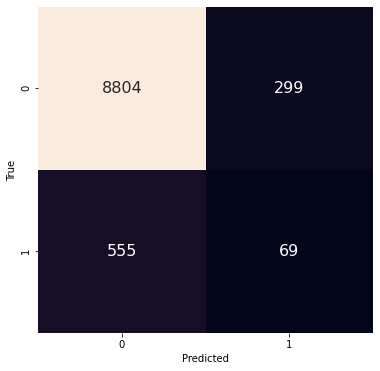

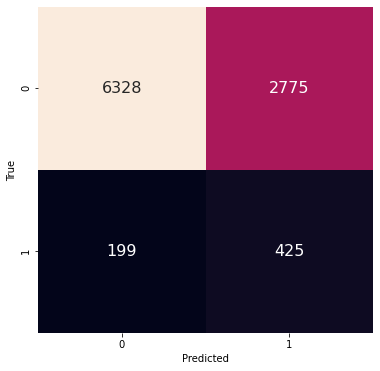

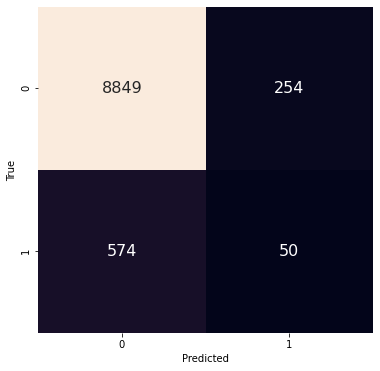

In [80]:
my_confusion_matrix(lgbm_predictions)
my_confusion_matrix(ridge_predictions)
my_confusion_matrix(rf_predictions)

La méthode Under-sampling avec le modèle Ridge offre les meilleurs résultats du point de vue du f-beta score.

## Interpretability LIME

Bien que Ridge offre les meilleures résultats, ce modèle n'est pas compatible avec les interpréteurs LIME et SHAP et apparaît ainsi comme une boîte noire. Nous préférons donc nous focaliser sur l'étude de LGBM et RF, que nous pouvons expliquer plus facilement.

In [81]:
lgbm_model = lgbm.LGBMClassifier(random_state = 42)
random_forest = RandomForestClassifier(random_state=42)

In [82]:
lgbm_model.fit(X_resampled, y_resampled)
random_forest.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [83]:
lgbm_predictions = lgbm_model.predict(test_features)
rf_predictions = random_forest.predict(test_features)

In [84]:
def LIME_test(model, train_features, test_features, train_labels, test_labels, features_names, idx):
    
    model.fit(train_features, train_labels)
    
    print("Test R^2 Score  : ", model.score(test_features, test_labels))
    print("Train R^2 Score : ", model.score(train_features, train_labels))
    
    explainer = lime_tabular.LimeTabularExplainer(train_features, feature_names=features_names)
    
   

    print("Prediction : ", model.predict(test_features[idx].reshape(1,-1)))
    print("Actual :     ", list(test_labels)[idx])

    explanation = explainer.explain_instance(test_features[idx], model.predict_proba, num_features=len(features_list))
    
    return explanation.show_in_notebook()

In [85]:
idx = 10
LIME_test(lgbm_model, X_resampled
          , test_features,y_resampled
          , test_labels, features_list, idx)

Test R^2 Score  :  0.6796545697542922
Train R^2 Score :  0.8967136150234741
Prediction :  [0]
Actual :      0


In [86]:
idx = 10
LIME_test(random_forest, X_resampled
          , test_features,y_resampled
          , test_labels, features_list, idx)

Test R^2 Score  :  0.6898324252081834
Train R^2 Score :  1.0
Prediction :  [0]
Actual :      0


## SHAP

In [87]:
X_resampled

array([[0.66724347, 0.65395574, 0.        , ..., 0.44685535, 0.5864    ,
        0.72      ],
       [0.59266309, 0.67202182, 0.5       , ..., 0.08835747, 0.        ,
        0.        ],
       [0.18140393, 0.80478933, 0.5       , ..., 0.26861724, 0.08      ,
        0.08      ],
       ...,
       [0.6424987 , 0.82994847, 0.5       , ..., 0.20674901, 0.04      ,
        0.04      ],
       [0.76235796, 0.94956047, 0.5       , ..., 0.26047523, 0.        ,
        0.        ],
       [0.52292784, 0.9389512 , 0.5       , ..., 0.13489712, 0.        ,
        0.        ]])

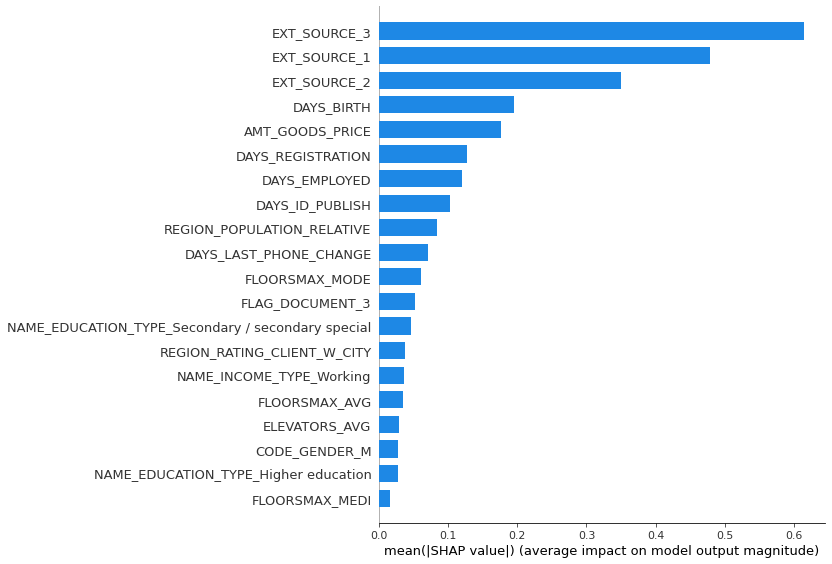

In [88]:
shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_resampled)
shap.summary_plot(shap_values, X_resampled, plot_type="bar", feature_names=features_list)

### Features Importance

In [89]:
#out of curiosity, let's take a look at our feature performance
def extract_feature_importance(model): 
    model_fi = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': features_list, 'Importance': model_fi})
    return feature_importances

lgbm_fi = extract_feature_importance(lgbm_model)
rf_fi = extract_feature_importance(random_forest)

In [90]:
lgbm_fi.sort_values(by='Importance')

Feature  Importance
21                              ORGANIZATION_TYPE_XNA           0
20                         NAME_INCOME_TYPE_Pensioner           0
10                                     FLAG_EMP_PHONE           0
25                             EMERGENCYSTATE_MODE_No           1
26                      HOUSETYPE_MODE_block of flats           3
19                                      CODE_GENDER_F           4
11                             REG_CITY_NOT_LIVE_CITY           5
8                              REG_CITY_NOT_WORK_CITY           5
13                           OCCUPATION_TYPE_Laborers           8
3                                REGION_RATING_CLIENT          10
23                                     FLOORSMAX_MEDI          13
30                                     ELEVATORS_MEDI          14
2                         REGION_RATING_CLIENT_W_CITY          20
12                                    FLAG_DOCUMENT_3          21
4                            NAME_INCOME_TYPE_Working          24
6                                       CODE_GENDER_M          25
9   NAME_EDUCATION_TYPE_Secondary / secondary special          32
18               NAME_EDUCATION_TYPE_Higher education          33
24                                     FLOORSMAX_MODE          33
29                                      ELEVATORS_AVG          52
22                                      FLOORSMAX_AVG          58
28                         REGION_POPULATION_RELATIVE         163
27                                    AMT_GOODS_PRICE         214
1                                       DAYS_EMPLOYED         227
5                              DAYS_LAST_PHONE_CHANGE         244
7                                     DAYS_ID_PUBLISH         273
14                                  DAYS_REGISTRATION         281
0                                          DAYS_BIRTH         288
16                                       EXT_SOURCE_2         308
15                                       EXT_SOURCE_3         310
17                                       EXT_SOURCE_1         331

In [91]:
rf_fi.sort_values(by='Importance')

Feature  Importance
21                              ORGANIZATION_TYPE_XNA    0.000000
20                         NAME_INCOME_TYPE_Pensioner    0.000000
10                                     FLAG_EMP_PHONE    0.000000
25                             EMERGENCYSTATE_MODE_No    0.001286
26                      HOUSETYPE_MODE_block of flats    0.003194
11                             REG_CITY_NOT_LIVE_CITY    0.003804
8                              REG_CITY_NOT_WORK_CITY    0.006999
6                                       CODE_GENDER_M    0.007539
19                                      CODE_GENDER_F    0.008056
18               NAME_EDUCATION_TYPE_Higher education    0.008608
13                           OCCUPATION_TYPE_Laborers    0.009437
12                                    FLAG_DOCUMENT_3    0.009789
9   NAME_EDUCATION_TYPE_Secondary / secondary special    0.010411
4                            NAME_INCOME_TYPE_Working    0.010638
3                                REGION_RATING_CLIENT    0.011191
2                         REGION_RATING_CLIENT_W_CITY    0.011840
30                                     ELEVATORS_MEDI    0.018193
24                                     FLOORSMAX_MODE    0.019414
29                                      ELEVATORS_AVG    0.019795
23                                     FLOORSMAX_MEDI    0.020733
22                                      FLOORSMAX_AVG    0.022130
28                         REGION_POPULATION_RELATIVE    0.052754
5                              DAYS_LAST_PHONE_CHANGE    0.058913
27                                    AMT_GOODS_PRICE    0.064133
7                                     DAYS_ID_PUBLISH    0.064756
14                                  DAYS_REGISTRATION    0.067212
0                                          DAYS_BIRTH    0.068989
1                                       DAYS_EMPLOYED    0.071700
16                                       EXT_SOURCE_2    0.101445
17                                       EXT_SOURCE_1    0.108213
15                                       EXT_SOURCE_3    0.138828

In [92]:
def plot_feature_importance(df, save=False):

    # Normalize the feature importances to add up to one
    df['Importance_normalized'] = df['Importance'] / df['Importance'].sum()
    df = df.sort_values('Importance_normalized', ascending = True).tail(20)

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (15, 16))

    ax = df.plot(x = 'Feature' , y = 'Importance_normalized', kind = 'barh', figsize=(10,10), color = 'blue')
    
    # Plot labeling
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    
    
    if save:
        plt.savefig('fi.jpg',  bbox_inches = 'tight')
        
    plt.show()
    
    # return top 20 features
    return(df['Feature'])

In [93]:
lgbm_fi

Feature  Importance
0                                          DAYS_BIRTH         288
1                                       DAYS_EMPLOYED         227
2                         REGION_RATING_CLIENT_W_CITY          20
3                                REGION_RATING_CLIENT          10
4                            NAME_INCOME_TYPE_Working          24
5                              DAYS_LAST_PHONE_CHANGE         244
6                                       CODE_GENDER_M          25
7                                     DAYS_ID_PUBLISH         273
8                              REG_CITY_NOT_WORK_CITY           5
9   NAME_EDUCATION_TYPE_Secondary / secondary special          32
10                                     FLAG_EMP_PHONE           0
11                             REG_CITY_NOT_LIVE_CITY           5
12                                    FLAG_DOCUMENT_3          21
13                           OCCUPATION_TYPE_Laborers           8
14                                  DAYS_REGISTRATION         281
15                                       EXT_SOURCE_3         310
16                                       EXT_SOURCE_2         308
17                                       EXT_SOURCE_1         331
18               NAME_EDUCATION_TYPE_Higher education          33
19                                      CODE_GENDER_F           4
20                         NAME_INCOME_TYPE_Pensioner           0
21                              ORGANIZATION_TYPE_XNA           0
22                                      FLOORSMAX_AVG          58
23                                     FLOORSMAX_MEDI          13
24                                     FLOORSMAX_MODE          33
25                             EMERGENCYSTATE_MODE_No           1
26                      HOUSETYPE_MODE_block of flats           3
27                                    AMT_GOODS_PRICE         214
28                         REGION_POPULATION_RELATIVE         163
29                                      ELEVATORS_AVG          52
30                                     ELEVATORS_MEDI          14

<Figure size 1080x1152 with 0 Axes>

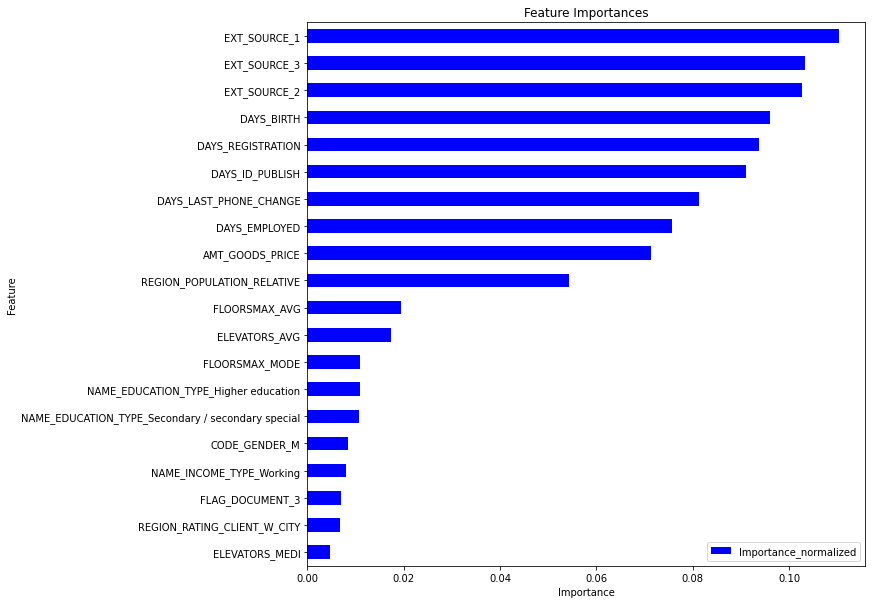

In [94]:
lgbm_top = plot_feature_importance(lgbm_fi, save=True)

<Figure size 1080x1152 with 0 Axes>

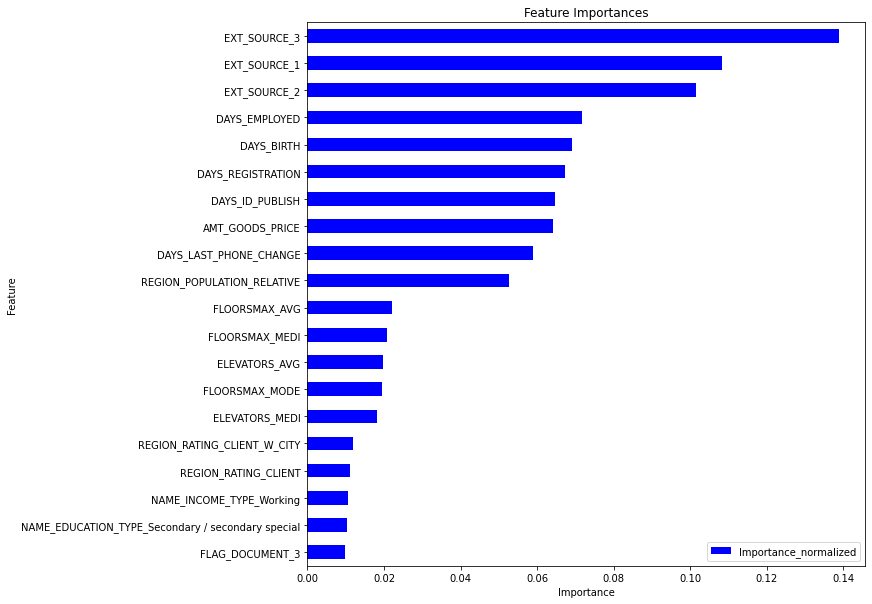

In [96]:
rf_top = plot_feature_importance(rf_fi)

### Sélection des features à l'aide de LOFO

In [97]:
features_list

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_Working',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'OCCUPATION_TYPE_Laborers',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'EMERGENCYSTATE_MODE_No',
 'HOUSETYPE_MODE_block of flats',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI']

In [98]:
dataset = Dataset(df=df, target="TARGET",features = features_list)

In [99]:
lofo_lgbm = LOFOImportance(dataset, model = lgbm_model, scoring=my_scorer)

In [100]:
#importance_df_lgbm = lofo_lgbm.get_importance()

In [101]:
#plot_importance(importance_df_lgbm, figsize=(12, 20))

## Optimisation LGBM

In [102]:
lgbm_model

LGBMClassifier(random_state=42)

In [103]:
my_estimator = lgbm.LGBMClassifier(random_state = 42)
my_params = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 150],
    'num_leaves': [25, 31, 37], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary', None],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [42],
    'colsample_bytree' : [0.99, 1, 1.01],
    'subsample' : [0.9, 1.0]
    }

In [154]:
my_gridsearch = GridSearchCV(estimator=my_estimator, param_grid=my_params, scoring=my_scorer, cv=cv)
my_gridsearch.fit(X_resampled, y_resampled)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=LGBMClassifier(random_state=42),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'colsample_bytree': [0.99, 1, 1.01],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_bin': [255, 510], 'n_estimators': [50, 100, 150],
                         'num_leaves': [25, 31, 37],
                         'objective': ['binary', None], 'random_state': [42],
                         'subsample': [0.9, 1.0]},
             scoring=make_scorer(fbeta_score, beta=3))

In [155]:
def get_new_scores(y_true, y_pred): 
    print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print('Precision: %.3f' % precision_score(y_true, y_pred))
    print('Recall: %.3f' % recall_score(y_true, y_pred))
    print('F1: %.3f' % f1_score(y_true, y_pred))
    print('FB: %.3f' % fbeta_score(y_true, y_pred, beta=3), '\n')

In [156]:
my_gridsearch.best_estimator_

LGBMClassifier(colsample_bytree=0.99, max_bin=255, n_estimators=50,
               objective='binary', random_state=42, subsample=0.9)

In [157]:
best_model = my_gridsearch.best_estimator_

best_model.fit(X_resampled, y_resampled)
preds = best_model.predict(test_features)

get_new_scores(test_labels, preds)

Accuracy: 0.686
Precision: 0.126
Recall: 0.660
F1: 0.212
FB: 0.464 



In [106]:
import pickle
Pkl_Filename = "../models/LGBM_model.pkl"  

In [159]:
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

In [107]:
with open(Pkl_Filename, 'rb') as file:
    my_best_model = pickle.load(file)

In [108]:
predictions = my_best_model.predict_proba(test)

In [109]:
predictions

array([[0.45161994, 0.54838006],
       [0.54285986, 0.45714014],
       [0.64254547, 0.35745453],
       ...,
       [0.64145737, 0.35854263],
       [0.56927899, 0.43072101],
       [0.45203231, 0.54796769]])

In [110]:
proba_remb = []
for i in predictions:
    proba_remb.append(i[0])

In [111]:
df_pred = pd.DataFrame()
df_pred['ID'] = original_test['SK_ID_CURR']
df_pred['Prediction'] = proba_remb

In [112]:
df_pred.to_csv('submission.csv')

## Création d'un dataframe pour le dashboard streamlit

In [113]:
original_test['AMT_REQ_CREDIT_BUREAU_YEAR']

0        0.0
1        3.0
2        4.0
3        3.0
4        NaN
        ... 
48739    1.0
48740    NaN
48741    1.0
48742    2.0
48743    4.0
Name: AMT_REQ_CREDIT_BUREAU_YEAR, Length: 48744, dtype: float64

In [114]:
original_test['DAYS_REGISTRATION'] / -365

0        14.164384
1        24.980822
2         5.958904
3         5.479452
4        10.958904
           ...    
48739    24.915068
48740     8.260274
48741     7.345205
48742     4.002740
48743     2.936986
Name: DAYS_REGISTRATION, Length: 48744, dtype: float64

In [115]:
original_test['AMT_CREDIT']

0         568800.0
1         222768.0
2         663264.0
3        1575000.0
4         625500.0
           ...    
48739     412560.0
48740     622413.0
48741     315000.0
48742     450000.0
48743     312768.0
Name: AMT_CREDIT, Length: 48744, dtype: float64

In [116]:
columns_test = ['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'AMT_ANNUITY', 'AMT_CREDIT']

In [117]:
df_db_test = pd.DataFrame()
df_db_test['Id_client'] = original_test['SK_ID_CURR'].astype(int)
df_db_test['Age'] = (original_test['DAYS_BIRTH'] / -365).astype(int)
df_db_test["Années d'emploi"] = (original_test['DAYS_EMPLOYED'] / -365).astype(int)
df_db_test['Ancienneté banque'] = (original_test['DAYS_REGISTRATION'] / -365).astype(int)
df_db_test['Annuité'] = original_test['AMT_ANNUITY'].astype(str)
df_db_test['Crédit demandé'] = original_test['AMT_CREDIT'].astype(str)
df_db_test["Durée d'endettement"] = (original_test['AMT_CREDIT'] / original_test['AMT_ANNUITY'])

In [118]:
df_db_test["Années d'emploi"].replace({-1000: np.nan}, inplace = True)

In [119]:
df_db_test.to_csv('../csv_files/vue_generale_test.csv')

In [120]:
df_db_train = pd.DataFrame()
df_db_train['Id_client'] = original_train['SK_ID_CURR'].astype(int)
df_db_train['Age'] = (original_train['DAYS_BIRTH'] / -365).astype(int)
df_db_train["Années d'emploi"] = (original_train['DAYS_EMPLOYED'] / -365).astype(int)
df_db_train['Ancienneté banque'] = (original_train['DAYS_REGISTRATION'] / -365).astype(int)
df_db_train['Annuité'] = original_train['AMT_ANNUITY'].astype(str)
df_db_train['Crédit demandé'] = original_train['AMT_CREDIT'].astype(str)
df_db_train['Prêt remboursé'] = original_train['TARGET']
df_db_train["Durée d'endettement"] = (original_train['AMT_CREDIT'] / original_train['AMT_ANNUITY'])

In [121]:
df_db_train["Années d\'emploi"].replace({-1000: np.nan}, inplace = True)

In [122]:
df_db_train['Prêt remboursé'].replace([0, 1], ['Oui', 'Non'], inplace=True)

In [123]:
df_db_test

Id_client  Age  Années d'emploi  Ancienneté banque  Annuité  \
0         100001   52              6.0                 14  20560.5   
1         100005   49             12.0                 24  17370.0   
2         100013   54             12.0                  5  69777.0   
3         100028   38              5.0                  5  49018.5   
4         100038   35              6.0                 10  32067.0   
...          ...  ...              ...                ...      ...   
48739     456221   54             14.0                 24  17473.5   
48740     456222   30              3.0                  8  31909.5   
48741     456223   43              8.0                  7  33205.5   
48742     456224   38              7.0                  4  25128.0   
48743     456250   38              1.0                  2  24709.5   

      Crédit demandé  Durée d'endettement  
0           568800.0            27.664697  
1           222768.0            12.824870  
2           663264.0             9.505482  
3          1575000.0            32.130726  
4           625500.0            19.506034  
...              ...                  ...  
48739       412560.0            23.610610  
48740       622413.0            19.505570  
48741       315000.0             9.486380  
48742       450000.0            17.908309  
48743       312768.0            12.657804  

[48744 rows x 7 columns]

In [124]:
df_db_train.to_csv('../csv_files/vue_generale_train.csv')

<AxesSubplot:>

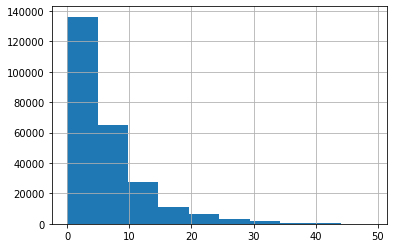

In [125]:
df_db_train['Années d\'emploi'].hist()

# Plus proche voisin

In [126]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# définition du modèle des plus proches voisins

df_nn = original_train[columns_test]
# on ajoute la cible
df_nn['TARGET'] = original_train['TARGET']
# on supprime les valeurs manquantes
df_nn.dropna(subset=columns_test, inplace=True)

#on standardise
std = StandardScaler()
df_std = std.fit_transform(df_nn[columns_test])
df_std = pd.DataFrame(df_std,
                      index=df_nn.index,
                      columns=[columns_test])

nn = NearestNeighbors(n_neighbors=6)
nn.fit(df_std)

NearestNeighbors(n_neighbors=6)

In [127]:
def train_nn(df_train, cols, n_neighbors=6):
    
    # Collecting data
    df_nn = df_train[cols]
    # Collecting target
    df_nn['TARGET'] = df_train['TARGET']
    # Get rid of NAN
    df_nn.dropna(subset=cols, inplace=True)

    # Standardisation
    std = StandardScaler()
    df_std = std.fit_transform(df_nn[cols])
    df_std = pd.DataFrame(df_std,
                          index=df_nn.index,
                          columns=[cols])
    
    # Train model
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(df_std)
    
    return nn, df_nn

In [128]:
def get_kneighbors(df_test, trained_model, cols, ID_client):


    # Collecting index of requested ID_client
    my_index = df_test[cols][df_test[cols]['SK_ID_CURR'] == ID_client].index[0]
    
    # Standaridation of data to predict
    client_list = std.transform(df_test[cols]) 
    
    # Prediction
    distance, voisins = nn.kneighbors([client_list[my_index]])
    voisins = voisins[0]
    
    # Create df with k nearest neighbours
    voisins_table = pd.DataFrame()
    for v in range(len(voisins)):
        voisins_table[v] = df_nn.iloc[voisins[v]]
    
    return voisins_table

In [129]:
my_nn, df_nn = train_nn(df_train=original_train, cols=columns_test)

In [130]:
Pkl_Filename = "nn_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(my_nn, file)

In [131]:
with open(Pkl_Filename, 'rb') as file:
    my_nn_load = pickle.load(file)

In [132]:
df_nn

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  AMT_ANNUITY  \
0           100002       -9461           -637            -3648.0      24700.5   
1           100003      -16765          -1188            -1186.0      35698.5   
2           100004      -19046           -225            -4260.0       6750.0   
3           100006      -19005          -3039            -9833.0      29686.5   
4           100007      -19932          -3038            -4311.0      21865.5   
...            ...         ...            ...                ...          ...   
307506      456251       -9327           -236            -8456.0      27558.0   
307507      456252      -20775         365243            -4388.0      12001.5   
307508      456253      -14966          -7921            -6737.0      29979.0   
307509      456254      -11961          -4786            -2562.0      20205.0   
307510      456255      -16856          -1262            -5128.0      49117.5   

        AMT_CREDIT  TARGET  
0         406597.5       1  
1        1293502.5       0  
2         135000.0       0  
3         312682.5       0  
4         513000.0       0  
...            ...     ...  
307506    254700.0       0  
307507    269550.0       0  
307508    677664.0       0  
307509    370107.0       1  
307510    675000.0       0  

[307499 rows x 7 columns]

In [133]:
df_nn.to_csv('../csv_files/df_nn.csv', index=False)

In [134]:
get_kneighbors(df_test=original_test, trained_model = my_nn_load, cols = columns_test, ID_client=100028)

0          1          2          3          4  \
SK_ID_CURR          116738.0   113526.0   110254.0   103003.0   102894.0   
DAYS_BIRTH          -13196.0   -14156.0   -13335.0   -13465.0   -14537.0   
DAYS_EMPLOYED        -5344.0    -5325.0    -1135.0     -359.0    -2118.0   
DAYS_REGISTRATION    -1703.0    -2116.0    -2064.0    -2344.0    -1883.0   
AMT_ANNUITY          49585.5    45333.0    45333.0    51556.5    44896.5   
AMT_CREDIT         1575000.0  1546020.0  1546020.0  1483231.5  1535553.0   
TARGET                   0.0        0.0        0.0        0.0        0.0   

                           5  
SK_ID_CURR          111770.0  
DAYS_BIRTH          -13774.0  
DAYS_EMPLOYED        -2684.0  
DAYS_REGISTRATION    -1763.0  
AMT_ANNUITY          53248.5  
AMT_CREDIT         1528200.0  
TARGET                   0.0

In [135]:
original_test.to_csv('../csv_files/original_test.csv', index=False)

In [136]:
original_train.to_csv('../csv_files/original_train.csv', index=False)

In [137]:
get_kneighbors(df_train=original_train, df_test=original_test, cols = columns_test, ID_client=100005)

TypeError: get_kneighbors() got an unexpected keyword argument 'df_train'

In [ ]:
data_test = original_test.dropna(subset=columns_test)

In [ ]:
data_test[columns_test]

In [ ]:
ID_client = 100005

In [ ]:
my_index = data_test[columns_test][data_test[columns_test]['SK_ID_CURR'] == ID_client].index[0]

In [ ]:
client_list = std.transform(data_test[columns_test]) 

In [ ]:
    distance, voisins = nn.kneighbors([client_list[1]])
    voisins = voisins[0]
    # on crée un dataframe avec les voisins
    voisins_table = pd.DataFrame()
    for v in range(len(voisins)):
        voisins_table[v] = df_nn.iloc[voisins[v]]

In [ ]:
client_list[10]

In [ ]:
voisins_table

In [ ]:
client_list = std.transform(data_test[columns_test])  # standardisation

for i in range(len(data_test)):
    distance, voisins = nn.kneighbors([client_list[i]])
    voisins = voisins[0]
    # on crée un dataframe avec les voisins
    voisins_table = pd.DataFrame()
    for v in range(len(voisins)):
        voisins_table[v] = df_nn.iloc[voisins[v]]
voisins_table.head()

In [ ]:
voisins_table

In [ ]:
client_list

In [ ]:
voisins_table

In [ ]:
def interpretable_sans_unite(df):
    """Fonction qui va rendre les colonnes d'un df interpretables (sans unité)"""
    df_int = pd.DataFrame(index=range(len(df)),
                          columns=['Identifiant',
                                   'Annuités',
                                   'Âge',
                                   'Début contrat travail',
                                   'Défaut paiement'])

    for i in range(len(df)) :
        df_int['Identifiant'].iloc[i] = int(df['SK_ID_CURR'].iloc[i])

        df_int['Annuités'].iloc[i] = df['AMT_ANNUITY'].iloc[i]

        df_int['Âge'].iloc[i] = np.around(df['DAYS_BIRTH'].iloc[i] / -365, decimals=1)

        df_int['Début contrat travail'].iloc[i] = np.around(df['DAYS_EMPLOYED'].iloc[i] / -365, decimals=1)

        if 'TARGET' in df.columns:
            if df['TARGET'].iloc[i] == 1.0:
                df_int['Défaut paiement'].iloc[i] = 'Oui'
            elif df['TARGET'].iloc[i] == 0:
                df_int['Défaut paiement'].iloc[i] = 'Non'
            else:
                df_int['Défaut paiement'].iloc[i] = 'Inconnu'
        else:
            df_int['Défaut paiement'].iloc[i] = 'Inconnu'

    return df_int

In [ ]:
interpretable_sans_unite(original_test)